# codes

In [38]:
from train_nn import train_nn
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def train_nn_cv(X, y, scaler_y,
                hidden_dims,
                activation='ReLU',
                lr=1e-3,
                weight_decay=0.0,
                epochs=50,
                batch_size=32,
                cv=5,
                random_state=42):
    """
    K-fold cross-validation with scatter plots and metrics on training and validation.
    Computes validation MSE (normalized), R², and Pearson correlation for both splits.
    At the end, prints lists of validation metrics (formatted to 4 decimal places)
    and their mean±std.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    fold_models    = []
    fold_val_loss  = []
    fold_val_r2    = []
    fold_val_corr  = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
        print(f"\n=== Fold {fold}/{cv} ===")
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Train on the training split
        model, train_loss_hist = train_nn(
            X_train, y_train,
            hidden_dims  = hidden_dims,
            activation   = activation,
            lr           = lr,
            weight_decay = weight_decay,
            epochs       = epochs,
            batch_size   = batch_size
        )

        model.eval()
        # ---- TRAINING METRICS & PLOT ----
        with torch.no_grad():
            pred_train_norm = model(torch.from_numpy(X_train).float()).cpu().numpy().ravel()
        true_train = scaler_y.inverse_transform(y_train.reshape(-1,1)).ravel()
        pred_train = scaler_y.inverse_transform(pred_train_norm.reshape(-1,1)).ravel()
        r2_train   = r2_score(true_train, pred_train)
        corr_train = np.corrcoef(true_train, pred_train)[0,1]
        print(f"Fold {fold} Training R²: {r2_train:.4f}, Pearson r: {corr_train:.4f}")

        plt.figure()
        plt.scatter(true_train, pred_train, alpha=0.6)
        mn, mx = true_train.min(), true_train.max()
        plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
        plt.xlabel('True Output')
        plt.ylabel('Predicted Output')
        plt.title(f'Fold {fold} — Training True vs. Predicted')
        plt.tight_layout()
        plt.show()

        # ---- VALIDATION METRICS & PLOT ----
        with torch.no_grad():
            pred_val_tensor = model(torch.from_numpy(X_val).float()).cpu()
        y_val_tensor = torch.from_numpy(y_val).unsqueeze(1)
        val_mse_norm = nn.MSELoss()(pred_val_tensor, y_val_tensor).item()
        pred_val_norm = pred_val_tensor.numpy().ravel()
        true_val = scaler_y.inverse_transform(y_val.reshape(-1,1)).ravel()
        pred_val = scaler_y.inverse_transform(pred_val_norm.reshape(-1,1)).ravel()
        r2_val   = r2_score(true_val, pred_val)
        corr_val = np.corrcoef(true_val, pred_val)[0,1]

        print(f"Fold {fold} Validation MSE (norm): {val_mse_norm:.4f}")
        print(f"Fold {fold} Validation R²: {r2_val:.4f}, Pearson r: {corr_val:.4f}")

        plt.figure()
        plt.scatter(true_val, pred_val, alpha=0.6)
        mn, mx = true_val.min(), true_val.max()
        plt.plot([mn, mx], [mn, mx], 'r--', linewidth=1)
        plt.xlabel('True Output')
        plt.ylabel('Predicted Output')
        plt.title(f'Fold {fold} — Validation True vs. Predicted')
        plt.tight_layout()
        plt.show()

        # collect validation metrics
        fold_models.append(model)
        fold_val_loss.append(val_mse_norm)
        fold_val_r2.append(r2_val)
        fold_val_corr.append(corr_val)

    # after all folds, summarize
    mean_mse = np.mean(fold_val_loss)
    std_mse  = np.std(fold_val_loss)
    mean_r2  = np.mean(fold_val_r2)
    std_r2   = np.std(fold_val_r2)
    mean_corr = np.mean(fold_val_corr)
    std_corr  = np.std(fold_val_corr)

    print("\n=== Validation MSE per fold ===")
    print([f"{v:.4f}" for v in fold_val_loss])
    print(f"Mean MSE (norm): {mean_mse:.4f} ± {std_mse:.4f}")

    print("\n=== Validation R² per fold ===")
    print([f"{v:.4f}" for v in fold_val_r2])
    print(f"Mean R²: {mean_r2:.4f} ± {std_r2:.4f}")

    print("\n=== Validation Pearson r per fold ===")
    print([f"{v:.4f}" for v in fold_val_corr])
    print(f"Mean Pearson r: {mean_corr:.4f} ± {std_corr:.4f}")

    return fold_models, fold_val_loss


# Removal of the Inputs

In [39]:
from data_preprocessing import preprocess_data
use_mask = [True] * 18
csv_path = '/home/kamiar/chevron/Acid-neural-net/data/training_validation.csv'
X, y, quality, scaler_X, scaler_y = preprocess_data(csv_path, use_mask)

# [3, 3] Relu


=== Fold 1/7 ===
Epoch   1/250  MSE=1.2967
Epoch  10/250  MSE=0.6733
Epoch  20/250  MSE=0.5036
Epoch  30/250  MSE=0.4212
Epoch  40/250  MSE=0.3657
Epoch  50/250  MSE=0.3220
Epoch  60/250  MSE=0.2747
Epoch  70/250  MSE=0.2401
Epoch  80/250  MSE=0.2133
Epoch  90/250  MSE=0.1907
Epoch 100/250  MSE=0.1731
Epoch 110/250  MSE=0.1591
Epoch 120/250  MSE=0.1476
Epoch 130/250  MSE=0.1357
Epoch 140/250  MSE=0.1275
Epoch 150/250  MSE=0.1160
Epoch 160/250  MSE=0.1040
Epoch 170/250  MSE=0.0932
Epoch 180/250  MSE=0.0869
Epoch 190/250  MSE=0.0863
Epoch 200/250  MSE=0.0742
Epoch 210/250  MSE=0.0736
Epoch 220/250  MSE=0.0657
Epoch 230/250  MSE=0.0633
Epoch 240/250  MSE=0.0619
Epoch 250/250  MSE=0.0586


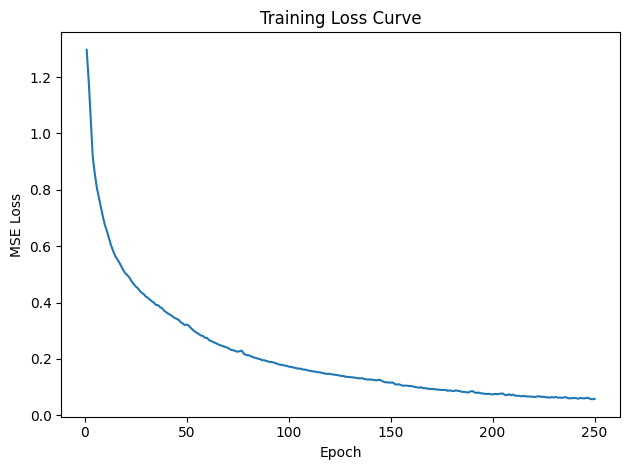

Fold 1 Training R²: 0.9505, Pearson r: 0.9766


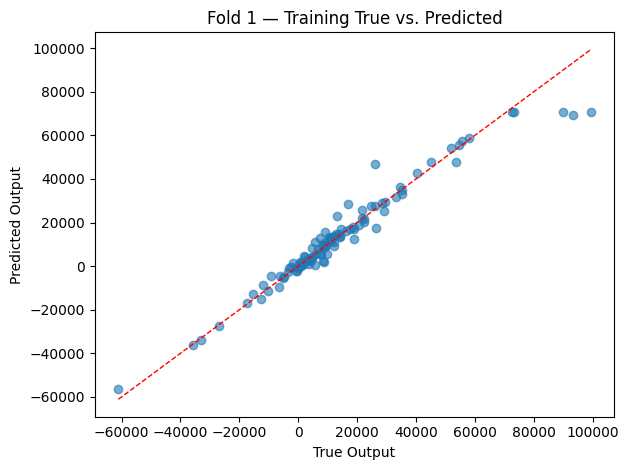

Fold 1 Validation MSE (norm): 0.1801
Fold 1 Validation R²: 0.0993, Pearson r: 0.6575


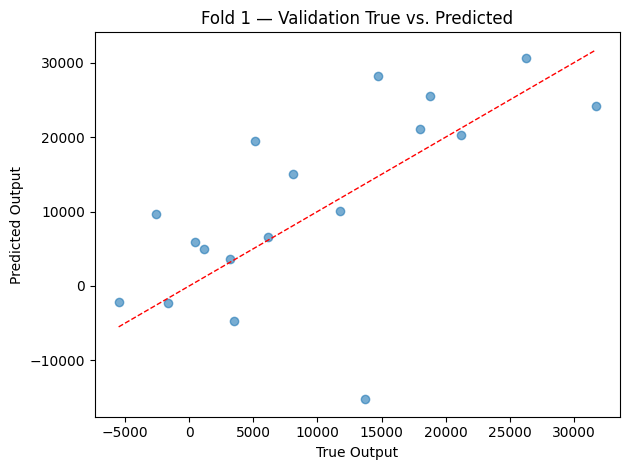


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9181
Epoch  10/250  MSE=0.6098
Epoch  20/250  MSE=0.3276
Epoch  30/250  MSE=0.2212
Epoch  40/250  MSE=0.1897
Epoch  50/250  MSE=0.1723
Epoch  60/250  MSE=0.1564
Epoch  70/250  MSE=0.1329
Epoch  80/250  MSE=0.1182
Epoch  90/250  MSE=0.1078
Epoch 100/250  MSE=0.1040
Epoch 110/250  MSE=0.0958
Epoch 120/250  MSE=0.0912
Epoch 130/250  MSE=0.0853
Epoch 140/250  MSE=0.0815
Epoch 150/250  MSE=0.0779
Epoch 160/250  MSE=0.0741
Epoch 170/250  MSE=0.0680
Epoch 180/250  MSE=0.0652
Epoch 190/250  MSE=0.0621
Epoch 200/250  MSE=0.0607
Epoch 210/250  MSE=0.0585
Epoch 220/250  MSE=0.0575
Epoch 230/250  MSE=0.0551
Epoch 240/250  MSE=0.0553
Epoch 250/250  MSE=0.0549


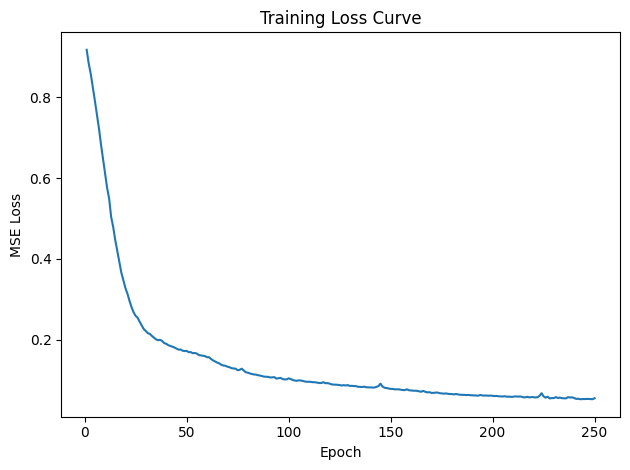

Fold 2 Training R²: 0.9432, Pearson r: 0.9722


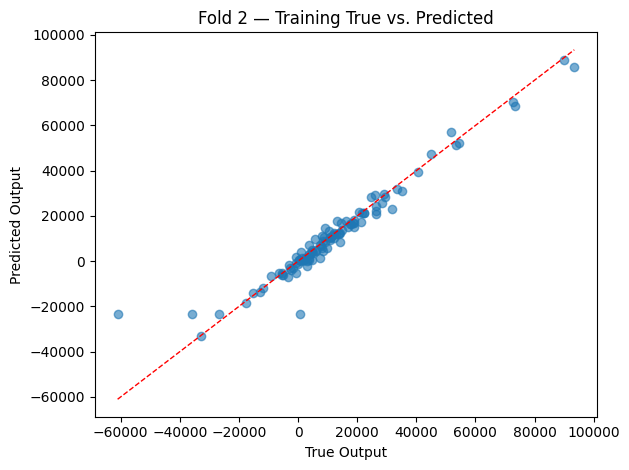

Fold 2 Validation MSE (norm): 0.2310
Fold 2 Validation R²: 0.8332, Pearson r: 0.9182


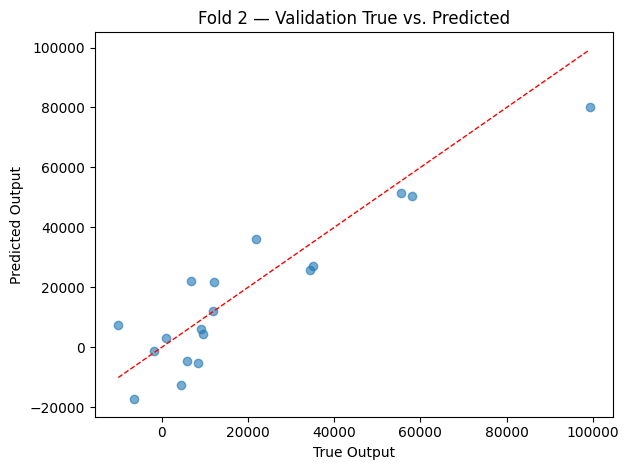


=== Fold 3/7 ===
Epoch   1/250  MSE=1.1581
Epoch  10/250  MSE=0.8258
Epoch  20/250  MSE=0.2644
Epoch  30/250  MSE=0.1798
Epoch  40/250  MSE=0.1541
Epoch  50/250  MSE=0.1370
Epoch  60/250  MSE=0.1300
Epoch  70/250  MSE=0.1255
Epoch  80/250  MSE=0.1232
Epoch  90/250  MSE=0.1199
Epoch 100/250  MSE=0.1157
Epoch 110/250  MSE=0.1140
Epoch 120/250  MSE=0.1135
Epoch 130/250  MSE=0.1097
Epoch 140/250  MSE=0.1069
Epoch 150/250  MSE=0.1068
Epoch 160/250  MSE=0.1057
Epoch 170/250  MSE=0.1054
Epoch 180/250  MSE=0.1051
Epoch 190/250  MSE=0.1036
Epoch 200/250  MSE=0.1032
Epoch 210/250  MSE=0.1034
Epoch 220/250  MSE=0.1047
Epoch 230/250  MSE=0.1040
Epoch 240/250  MSE=0.1035
Epoch 250/250  MSE=0.1021


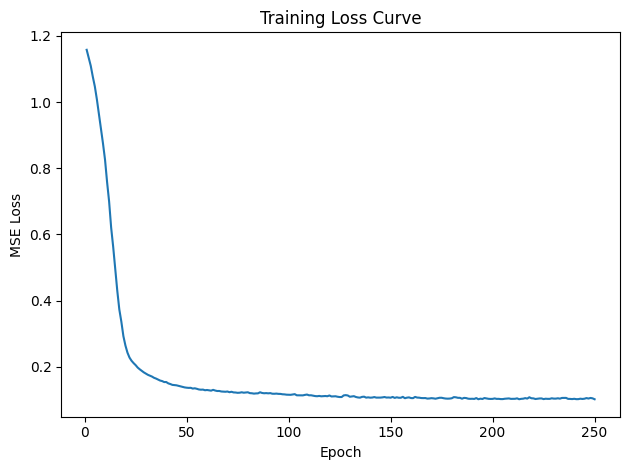

Fold 3 Training R²: 0.9011, Pearson r: 0.9498


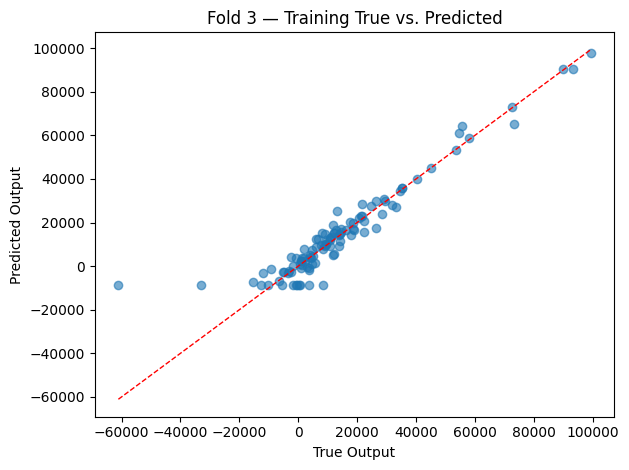

Fold 3 Validation MSE (norm): 0.4312
Fold 3 Validation R²: 0.4052, Pearson r: 0.8127


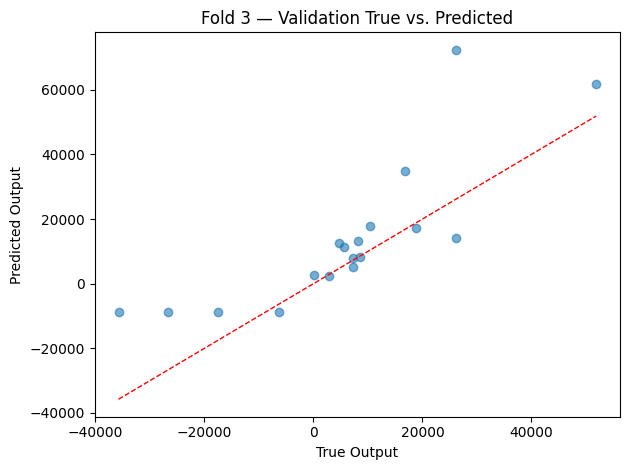


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8205
Epoch  10/250  MSE=0.6314
Epoch  20/250  MSE=0.1238
Epoch  30/250  MSE=0.0624
Epoch  40/250  MSE=0.0530
Epoch  50/250  MSE=0.0437
Epoch  60/250  MSE=0.0407
Epoch  70/250  MSE=0.0381
Epoch  80/250  MSE=0.0364
Epoch  90/250  MSE=0.0361
Epoch 100/250  MSE=0.0351
Epoch 110/250  MSE=0.0331
Epoch 120/250  MSE=0.0335
Epoch 130/250  MSE=0.0310
Epoch 140/250  MSE=0.0306
Epoch 150/250  MSE=0.0273
Epoch 160/250  MSE=0.0270
Epoch 170/250  MSE=0.0319
Epoch 180/250  MSE=0.0246
Epoch 190/250  MSE=0.0219
Epoch 200/250  MSE=0.0216
Epoch 210/250  MSE=0.0196
Epoch 220/250  MSE=0.0192
Epoch 230/250  MSE=0.0178
Epoch 240/250  MSE=0.0187
Epoch 250/250  MSE=0.0168


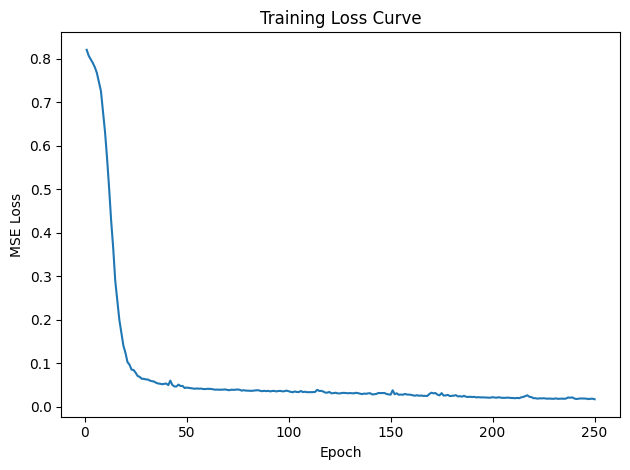

Fold 4 Training R²: 0.9791, Pearson r: 0.9899


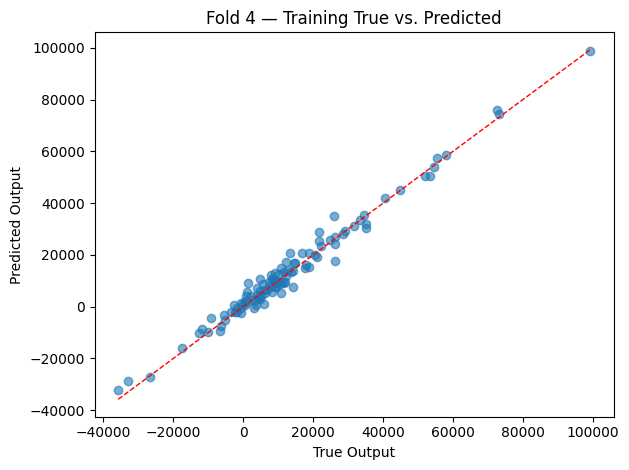

Fold 4 Validation MSE (norm): 1.4039
Fold 4 Validation R²: 0.3537, Pearson r: 0.6209


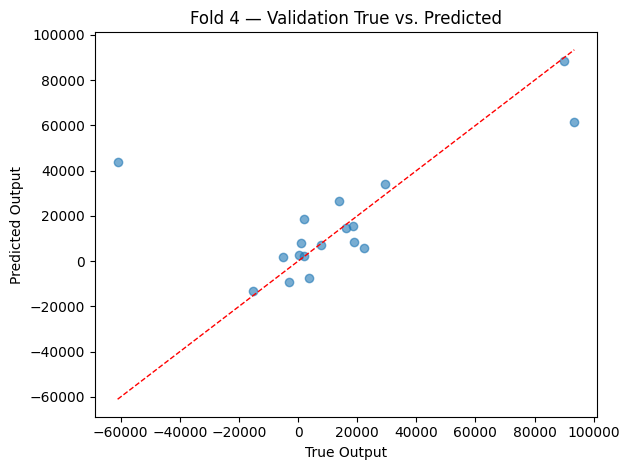


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0518
Epoch  10/250  MSE=0.8201
Epoch  20/250  MSE=0.6090
Epoch  30/250  MSE=0.4935
Epoch  40/250  MSE=0.4202
Epoch  50/250  MSE=0.3681
Epoch  60/250  MSE=0.3230
Epoch  70/250  MSE=0.2864
Epoch  80/250  MSE=0.2524
Epoch  90/250  MSE=0.2245
Epoch 100/250  MSE=0.2033
Epoch 110/250  MSE=0.1797
Epoch 120/250  MSE=0.1641
Epoch 130/250  MSE=0.1506
Epoch 140/250  MSE=0.1410
Epoch 150/250  MSE=0.1304
Epoch 160/250  MSE=0.1231
Epoch 170/250  MSE=0.1172
Epoch 180/250  MSE=0.1119
Epoch 190/250  MSE=0.1055
Epoch 200/250  MSE=0.1022
Epoch 210/250  MSE=0.0981
Epoch 220/250  MSE=0.0966
Epoch 230/250  MSE=0.0923
Epoch 240/250  MSE=0.0871
Epoch 250/250  MSE=0.0823


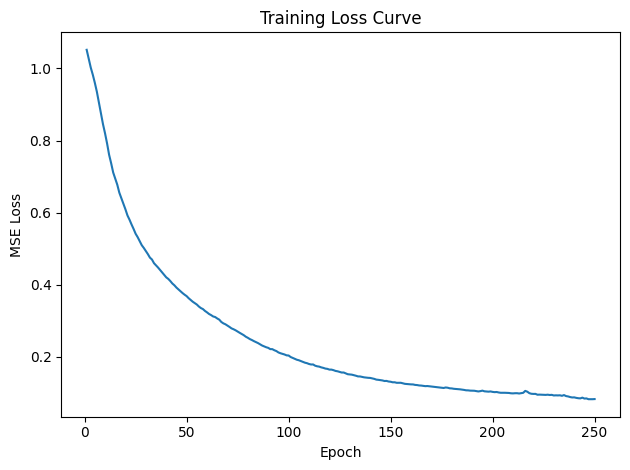

Fold 5 Training R²: 0.9218, Pearson r: 0.9639


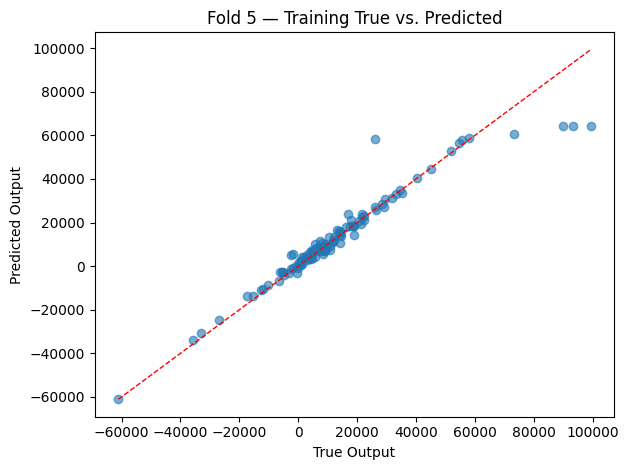

Fold 5 Validation MSE (norm): 0.2026
Fold 5 Validation R²: 0.7419, Pearson r: 0.8709


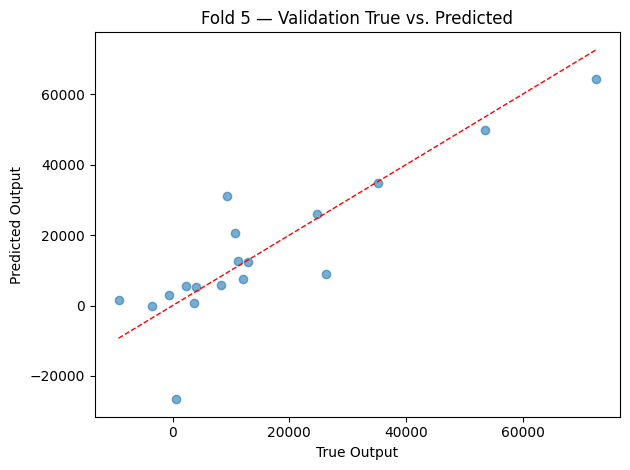


=== Fold 6/7 ===
Epoch   1/250  MSE=1.2713
Epoch  10/250  MSE=0.7434
Epoch  20/250  MSE=0.5079
Epoch  30/250  MSE=0.4316
Epoch  40/250  MSE=0.3815
Epoch  50/250  MSE=0.3475
Epoch  60/250  MSE=0.3170
Epoch  70/250  MSE=0.2946
Epoch  80/250  MSE=0.2561
Epoch  90/250  MSE=0.2346
Epoch 100/250  MSE=0.2153
Epoch 110/250  MSE=0.1950
Epoch 120/250  MSE=0.1758
Epoch 130/250  MSE=0.1623
Epoch 140/250  MSE=0.1495
Epoch 150/250  MSE=0.1385
Epoch 160/250  MSE=0.1296
Epoch 170/250  MSE=0.1225
Epoch 180/250  MSE=0.1161
Epoch 190/250  MSE=0.1121
Epoch 200/250  MSE=0.1076
Epoch 210/250  MSE=0.1033
Epoch 220/250  MSE=0.1003
Epoch 230/250  MSE=0.0973
Epoch 240/250  MSE=0.0952
Epoch 250/250  MSE=0.0925


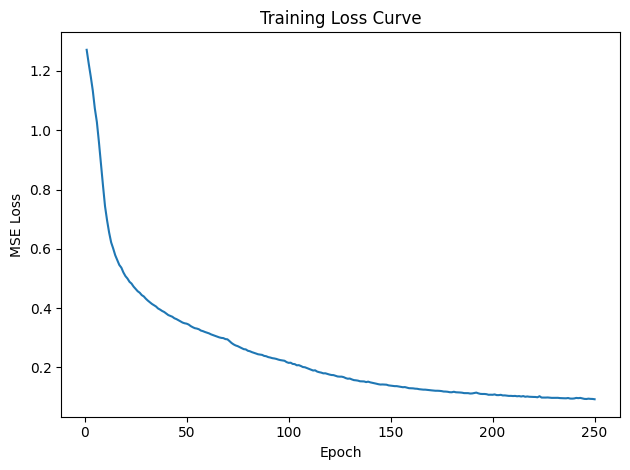

Fold 6 Training R²: 0.9079, Pearson r: 0.9557


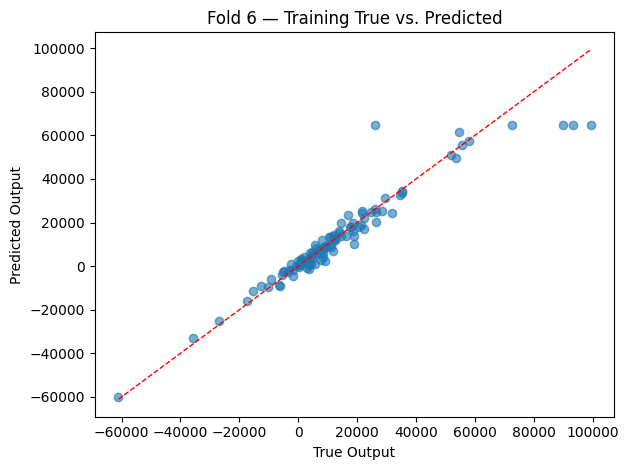

Fold 6 Validation MSE (norm): 0.5354
Fold 6 Validation R²: 0.4990, Pearson r: 0.7158


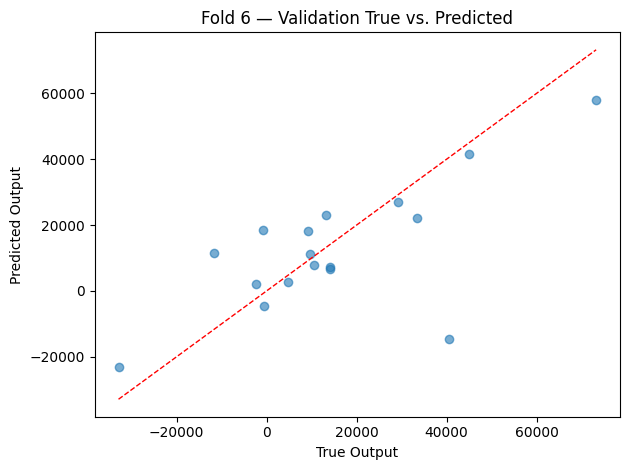


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1525
Epoch  10/250  MSE=0.8435
Epoch  20/250  MSE=0.4299
Epoch  30/250  MSE=0.1376
Epoch  40/250  MSE=0.0891
Epoch  50/250  MSE=0.0729
Epoch  60/250  MSE=0.0648
Epoch  70/250  MSE=0.0565
Epoch  80/250  MSE=0.0516
Epoch  90/250  MSE=0.0483
Epoch 100/250  MSE=0.0490
Epoch 110/250  MSE=0.0426
Epoch 120/250  MSE=0.0390
Epoch 130/250  MSE=0.0370
Epoch 140/250  MSE=0.0361
Epoch 150/250  MSE=0.0334
Epoch 160/250  MSE=0.0317
Epoch 170/250  MSE=0.0304
Epoch 180/250  MSE=0.0294
Epoch 190/250  MSE=0.0290
Epoch 200/250  MSE=0.0284
Epoch 210/250  MSE=0.0284
Epoch 220/250  MSE=0.0281
Epoch 230/250  MSE=0.0275
Epoch 240/250  MSE=0.0265
Epoch 250/250  MSE=0.0274


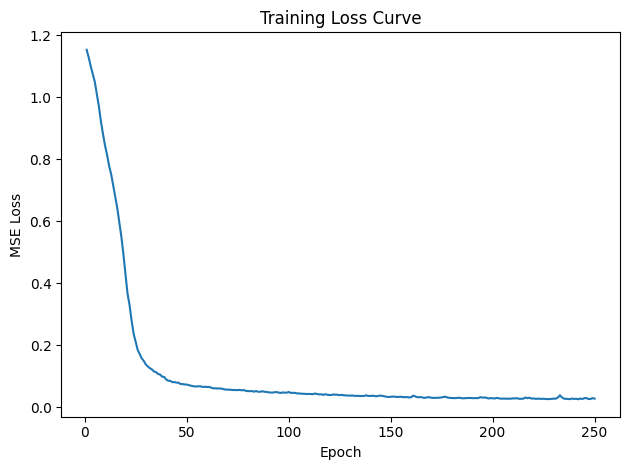

Fold 7 Training R²: 0.9772, Pearson r: 0.9889


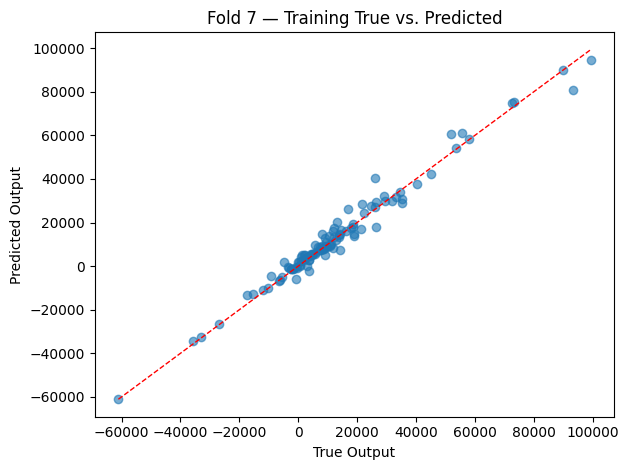

Fold 7 Validation MSE (norm): 0.1417
Fold 7 Validation R²: 0.6624, Pearson r: 0.8405


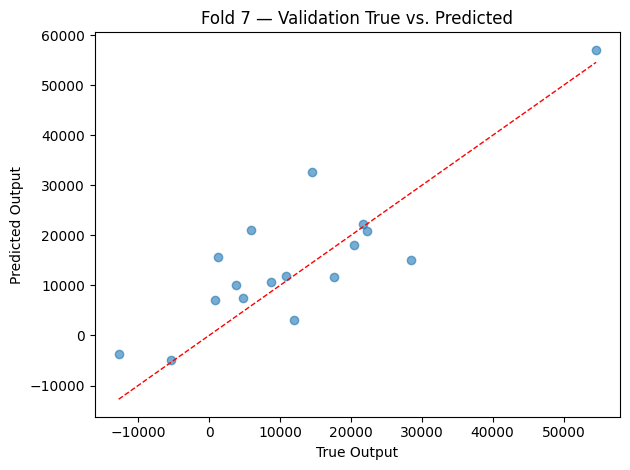


=== Validation MSE per fold ===
['0.1801', '0.2310', '0.4312', '1.4039', '0.2026', '0.5354', '0.1417']
Mean MSE (norm): 0.4466 ± 0.4131

=== Validation R² per fold ===
['0.0993', '0.8332', '0.4052', '0.3537', '0.7419', '0.4990', '0.6624']
Mean R²: 0.5135 ± 0.2347

=== Validation Pearson r per fold ===
['0.6575', '0.9182', '0.8127', '0.6209', '0.8709', '0.7158', '0.8405']
Mean Pearson r: 0.7767 ± 0.1045


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [40]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [3, 3],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")
'''
'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [8, 8],'ReLU',


=== Fold 1/7 ===
Epoch   1/250  MSE=1.1818


Epoch  10/250  MSE=0.4675
Epoch  20/250  MSE=0.1037
Epoch  30/250  MSE=0.0619
Epoch  40/250  MSE=0.0405
Epoch  50/250  MSE=0.0322
Epoch  60/250  MSE=0.0310
Epoch  70/250  MSE=0.0233
Epoch  80/250  MSE=0.0186
Epoch  90/250  MSE=0.0170
Epoch 100/250  MSE=0.0140
Epoch 110/250  MSE=0.0115
Epoch 120/250  MSE=0.0104
Epoch 130/250  MSE=0.0123
Epoch 140/250  MSE=0.0093
Epoch 150/250  MSE=0.0084
Epoch 160/250  MSE=0.0107
Epoch 170/250  MSE=0.0072
Epoch 180/250  MSE=0.0061
Epoch 190/250  MSE=0.0059
Epoch 200/250  MSE=0.0066
Epoch 210/250  MSE=0.0087
Epoch 220/250  MSE=0.0137
Epoch 230/250  MSE=0.0085
Epoch 240/250  MSE=0.0087
Epoch 250/250  MSE=0.0077


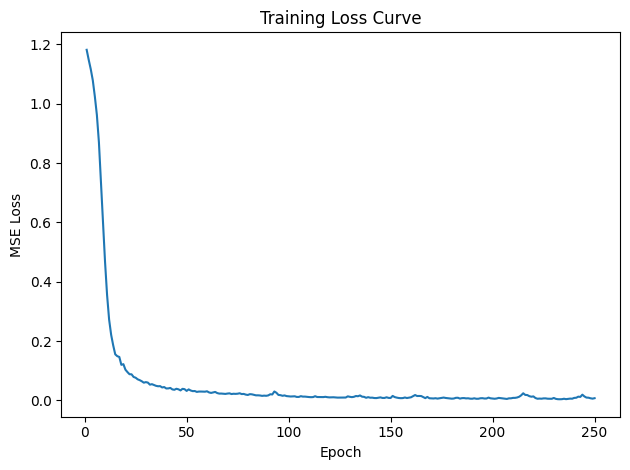

Fold 1 Training R²: 0.9943, Pearson r: 0.9976


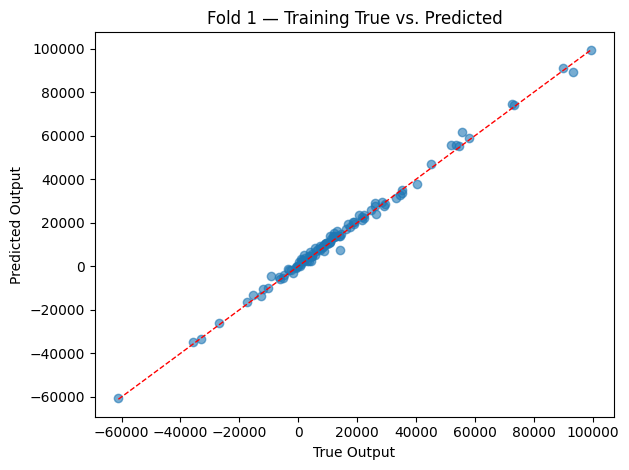

Fold 1 Validation MSE (norm): 0.1712
Fold 1 Validation R²: 0.1437, Pearson r: 0.7155


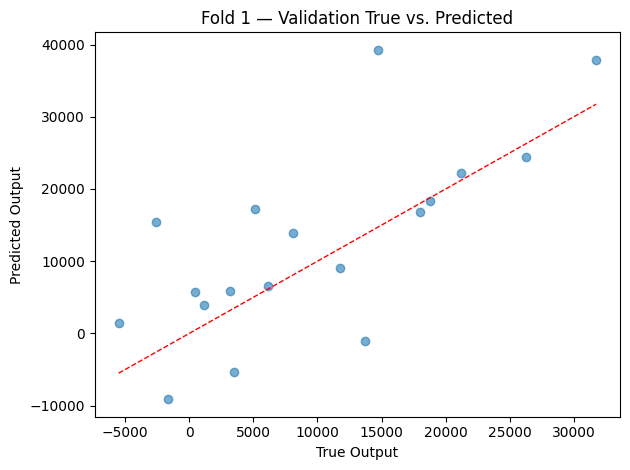


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9419
Epoch  10/250  MSE=0.5372
Epoch  20/250  MSE=0.1157
Epoch  30/250  MSE=0.0649
Epoch  40/250  MSE=0.0433
Epoch  50/250  MSE=0.0300
Epoch  60/250  MSE=0.0275
Epoch  70/250  MSE=0.0198
Epoch  80/250  MSE=0.0160
Epoch  90/250  MSE=0.0137
Epoch 100/250  MSE=0.0118
Epoch 110/250  MSE=0.0109
Epoch 120/250  MSE=0.0111
Epoch 130/250  MSE=0.0130
Epoch 140/250  MSE=0.0116
Epoch 150/250  MSE=0.0072
Epoch 160/250  MSE=0.0054
Epoch 170/250  MSE=0.0473
Epoch 180/250  MSE=0.0044
Epoch 190/250  MSE=0.0042
Epoch 200/250  MSE=0.0036
Epoch 210/250  MSE=0.0034
Epoch 220/250  MSE=0.0030
Epoch 230/250  MSE=0.0051
Epoch 240/250  MSE=0.0037
Epoch 250/250  MSE=0.0051


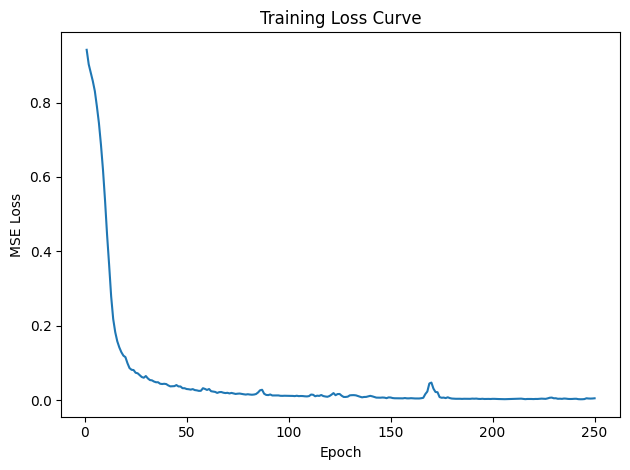

Fold 2 Training R²: 0.9957, Pearson r: 0.9978


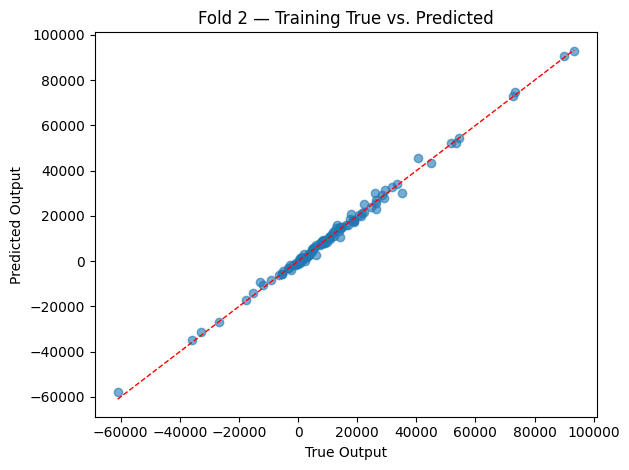

Fold 2 Validation MSE (norm): 0.2947
Fold 2 Validation R²: 0.7872, Pearson r: 0.8894


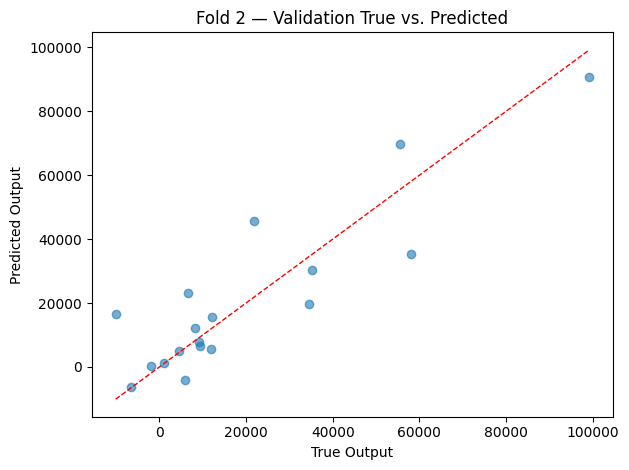


=== Fold 3/7 ===
Epoch   1/250  MSE=1.1043
Epoch  10/250  MSE=0.6614
Epoch  20/250  MSE=0.1348
Epoch  30/250  MSE=0.0479
Epoch  40/250  MSE=0.0292
Epoch  50/250  MSE=0.0203
Epoch  60/250  MSE=0.0187
Epoch  70/250  MSE=0.0152
Epoch  80/250  MSE=0.0120
Epoch  90/250  MSE=0.0142
Epoch 100/250  MSE=0.0102
Epoch 110/250  MSE=0.0096
Epoch 120/250  MSE=0.0084
Epoch 130/250  MSE=0.0077
Epoch 140/250  MSE=0.0070
Epoch 150/250  MSE=0.0070
Epoch 160/250  MSE=0.0077
Epoch 170/250  MSE=0.0072
Epoch 180/250  MSE=0.0062
Epoch 190/250  MSE=0.0069
Epoch 200/250  MSE=0.0104
Epoch 210/250  MSE=0.0068
Epoch 220/250  MSE=0.0056
Epoch 230/250  MSE=0.0054
Epoch 240/250  MSE=0.0060
Epoch 250/250  MSE=0.0058


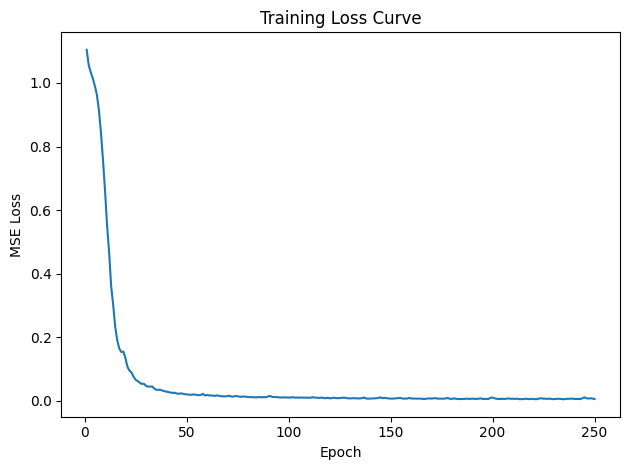

Fold 3 Training R²: 0.9954, Pearson r: 0.9978


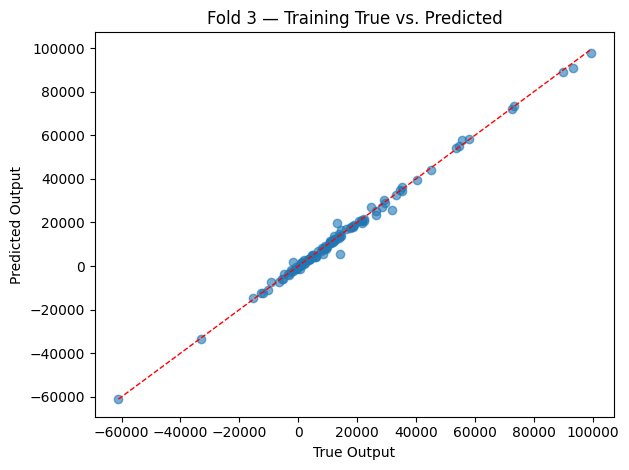

Fold 3 Validation MSE (norm): 0.2655
Fold 3 Validation R²: 0.6338, Pearson r: 0.9064


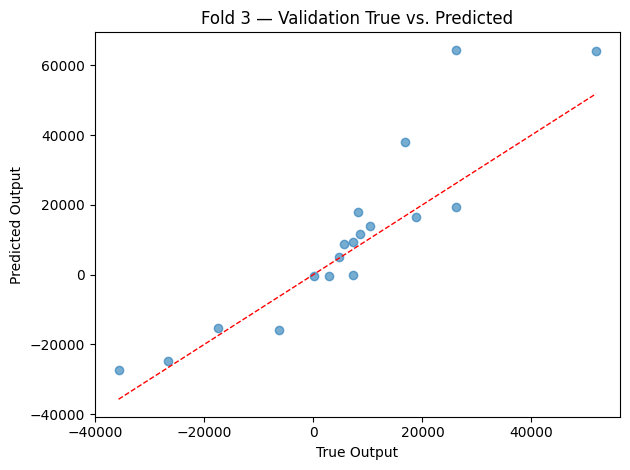


=== Fold 4/7 ===
Epoch   1/250  MSE=0.7862
Epoch  10/250  MSE=0.1991
Epoch  20/250  MSE=0.0542
Epoch  30/250  MSE=0.0382
Epoch  40/250  MSE=0.0304
Epoch  50/250  MSE=0.0248
Epoch  60/250  MSE=0.0254
Epoch  70/250  MSE=0.0217
Epoch  80/250  MSE=0.0180
Epoch  90/250  MSE=0.0203
Epoch 100/250  MSE=0.0134
Epoch 110/250  MSE=0.0103
Epoch 120/250  MSE=0.0124
Epoch 130/250  MSE=0.0092
Epoch 140/250  MSE=0.0069
Epoch 150/250  MSE=0.0078
Epoch 160/250  MSE=0.0056
Epoch 170/250  MSE=0.0087
Epoch 180/250  MSE=0.0056
Epoch 190/250  MSE=0.0065
Epoch 200/250  MSE=0.0069
Epoch 210/250  MSE=0.0050
Epoch 220/250  MSE=0.0038
Epoch 230/250  MSE=0.0071
Epoch 240/250  MSE=0.0123
Epoch 250/250  MSE=0.0045


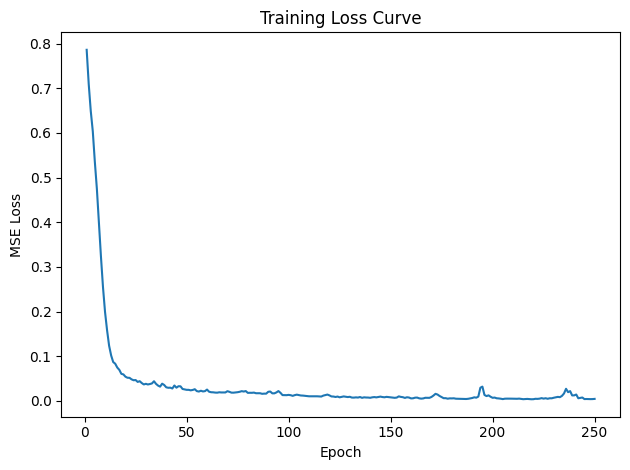

Fold 4 Training R²: 0.9957, Pearson r: 0.9980


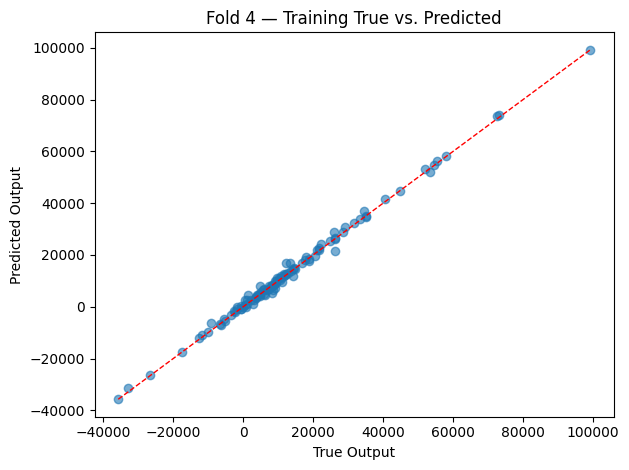

Fold 4 Validation MSE (norm): 1.5820
Fold 4 Validation R²: 0.2717, Pearson r: 0.5394


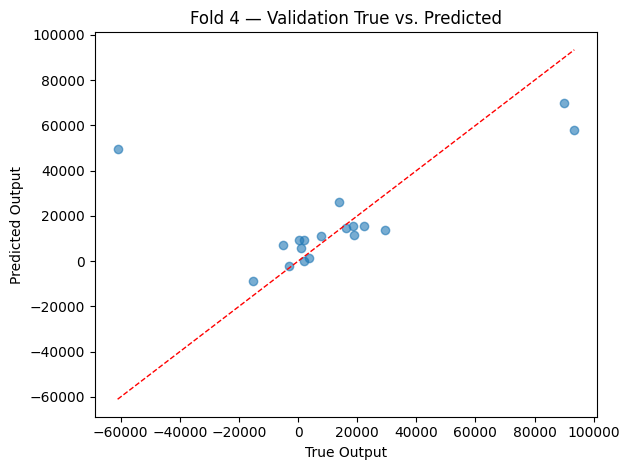


=== Fold 5/7 ===
Epoch   1/250  MSE=1.1554
Epoch  10/250  MSE=0.3918
Epoch  20/250  MSE=0.1052
Epoch  30/250  MSE=0.0674
Epoch  40/250  MSE=0.0552
Epoch  50/250  MSE=0.0485
Epoch  60/250  MSE=0.0436
Epoch  70/250  MSE=0.0376
Epoch  80/250  MSE=0.0336
Epoch  90/250  MSE=0.0291
Epoch 100/250  MSE=0.0257
Epoch 110/250  MSE=0.0228
Epoch 120/250  MSE=0.0214
Epoch 130/250  MSE=0.0220
Epoch 140/250  MSE=0.0184
Epoch 150/250  MSE=0.0163
Epoch 160/250  MSE=0.0182
Epoch 170/250  MSE=0.0156
Epoch 180/250  MSE=0.0175
Epoch 190/250  MSE=0.0125
Epoch 200/250  MSE=0.0105
Epoch 210/250  MSE=0.0110
Epoch 220/250  MSE=0.0109
Epoch 230/250  MSE=0.0133
Epoch 240/250  MSE=0.0085
Epoch 250/250  MSE=0.0068


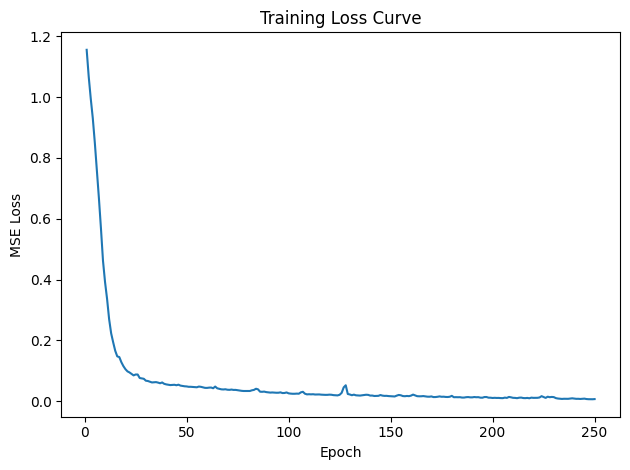

Fold 5 Training R²: 0.9944, Pearson r: 0.9973


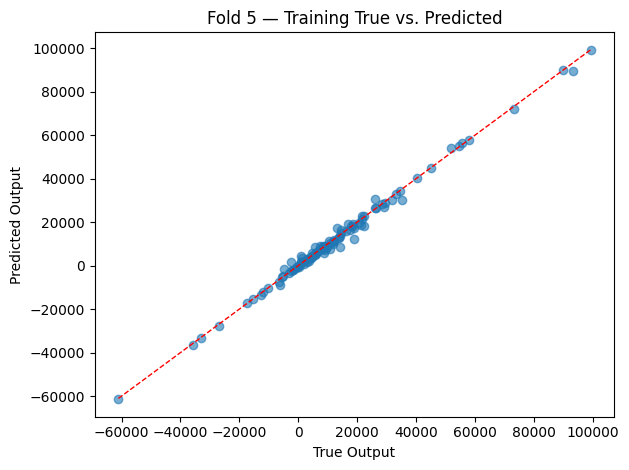

Fold 5 Validation MSE (norm): 0.5443
Fold 5 Validation R²: 0.3068, Pearson r: 0.8425


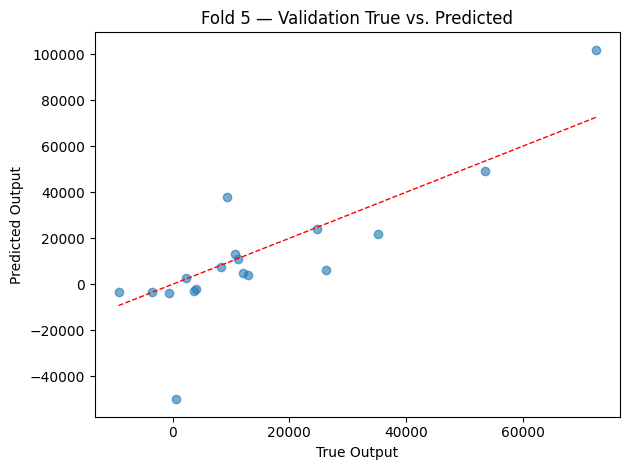


=== Fold 6/7 ===
Epoch   1/250  MSE=1.0689
Epoch  10/250  MSE=0.5522
Epoch  20/250  MSE=0.1296
Epoch  30/250  MSE=0.0777
Epoch  40/250  MSE=0.0623
Epoch  50/250  MSE=0.0479
Epoch  60/250  MSE=0.0405
Epoch  70/250  MSE=0.0361
Epoch  80/250  MSE=0.0329
Epoch  90/250  MSE=0.0308
Epoch 100/250  MSE=0.0240
Epoch 110/250  MSE=0.0199
Epoch 120/250  MSE=0.0186
Epoch 130/250  MSE=0.0147
Epoch 140/250  MSE=0.0097
Epoch 150/250  MSE=0.0084
Epoch 160/250  MSE=0.0056
Epoch 170/250  MSE=0.0055
Epoch 180/250  MSE=0.0042
Epoch 190/250  MSE=0.0031
Epoch 200/250  MSE=0.0034
Epoch 210/250  MSE=0.0038
Epoch 220/250  MSE=0.0027
Epoch 230/250  MSE=0.0022
Epoch 240/250  MSE=0.0036
Epoch 250/250  MSE=0.0031


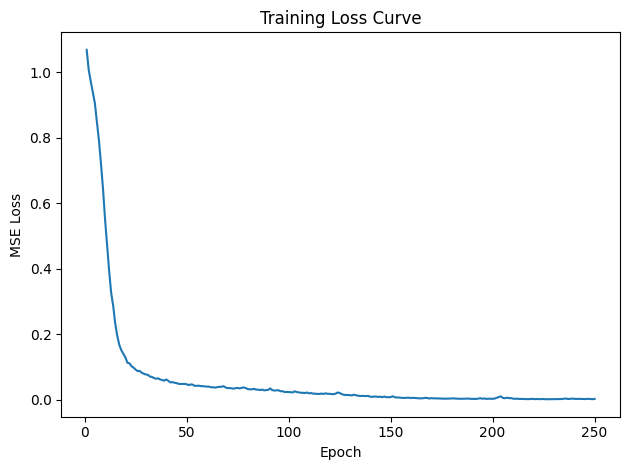

Fold 6 Training R²: 0.9973, Pearson r: 0.9990


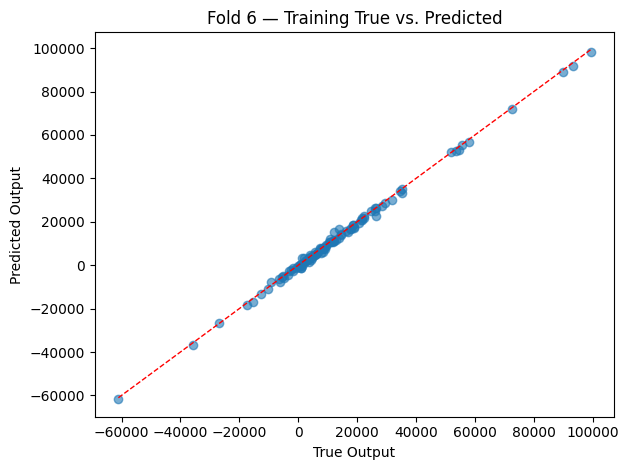

Fold 6 Validation MSE (norm): 0.7463
Fold 6 Validation R²: 0.3017, Pearson r: 0.6518


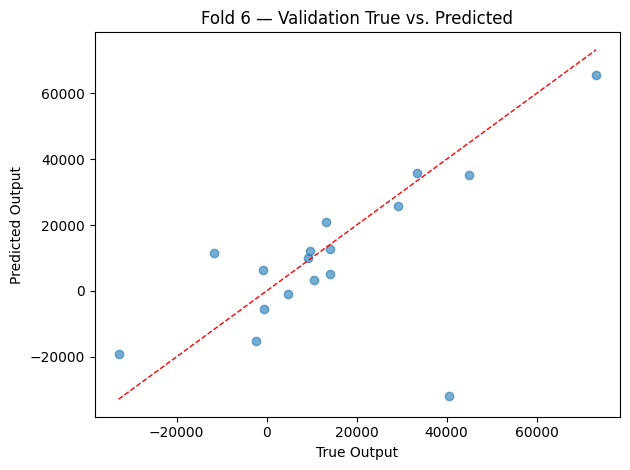


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1460
Epoch  10/250  MSE=0.3540
Epoch  20/250  MSE=0.1148
Epoch  30/250  MSE=0.0675
Epoch  40/250  MSE=0.0484
Epoch  50/250  MSE=0.0408
Epoch  60/250  MSE=0.0325
Epoch  70/250  MSE=0.0284
Epoch  80/250  MSE=0.0264
Epoch  90/250  MSE=0.0208
Epoch 100/250  MSE=0.0184
Epoch 110/250  MSE=0.0184
Epoch 120/250  MSE=0.0187
Epoch 130/250  MSE=0.0134
Epoch 140/250  MSE=0.0122
Epoch 150/250  MSE=0.0115
Epoch 160/250  MSE=0.0084
Epoch 170/250  MSE=0.0155
Epoch 180/250  MSE=0.0081
Epoch 190/250  MSE=0.0070
Epoch 200/250  MSE=0.0068
Epoch 210/250  MSE=0.0058
Epoch 220/250  MSE=0.0087
Epoch 230/250  MSE=0.0087
Epoch 240/250  MSE=0.0086
Epoch 250/250  MSE=0.0034


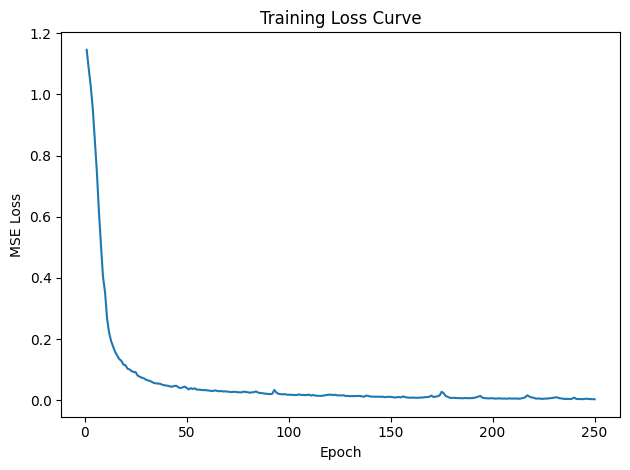

Fold 7 Training R²: 0.9969, Pearson r: 0.9987


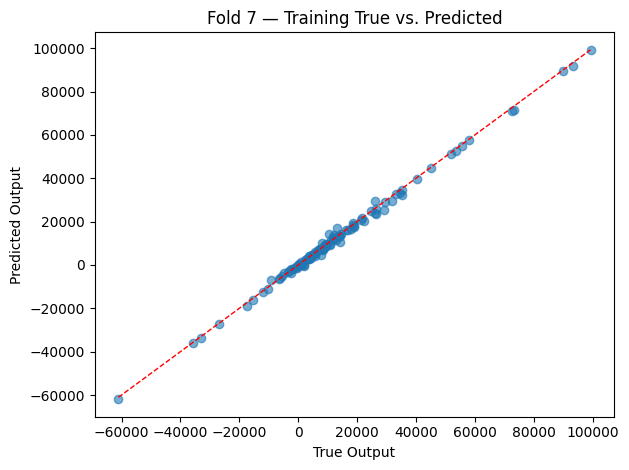

Fold 7 Validation MSE (norm): 0.2220
Fold 7 Validation R²: 0.4710, Pearson r: 0.7211


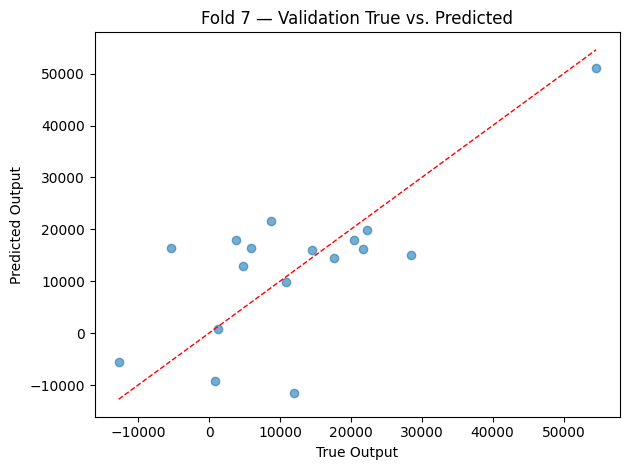


=== Validation MSE per fold ===
['0.1712', '0.2947', '0.2655', '1.5820', '0.5443', '0.7463', '0.2220']
Mean MSE (norm): 0.5466 ± 0.4630

=== Validation R² per fold ===
['0.1437', '0.7872', '0.6338', '0.2717', '0.3068', '0.3017', '0.4710']
Mean R²: 0.4166 ± 0.2098

=== Validation Pearson r per fold ===
['0.7155', '0.8894', '0.9064', '0.5394', '0.8425', '0.6518', '0.7211']
Mean Pearson r: 0.7523 ± 0.1245


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [41]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [8, 8],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")
'''
'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [12] Relu


=== Fold 1/7 ===
Epoch   1/250  MSE=1.0791
Epoch  10/250  MSE=0.4559
Epoch  20/250  MSE=0.1287
Epoch  30/250  MSE=0.0633
Epoch  40/250  MSE=0.0390
Epoch  50/250  MSE=0.0301
Epoch  60/250  MSE=0.0253
Epoch  70/250  MSE=0.0194
Epoch  80/250  MSE=0.0191
Epoch  90/250  MSE=0.0144
Epoch 100/250  MSE=0.0138
Epoch 110/250  MSE=0.0124
Epoch 120/250  MSE=0.0095
Epoch 130/250  MSE=0.0105
Epoch 140/250  MSE=0.0081
Epoch 150/250  MSE=0.0080
Epoch 160/250  MSE=0.0066
Epoch 170/250  MSE=0.0079
Epoch 180/250  MSE=0.0179
Epoch 190/250  MSE=0.0065
Epoch 200/250  MSE=0.0045
Epoch 210/250  MSE=0.0050
Epoch 220/250  MSE=0.0042
Epoch 230/250  MSE=0.0049
Epoch 240/250  MSE=0.0034
Epoch 250/250  MSE=0.0104


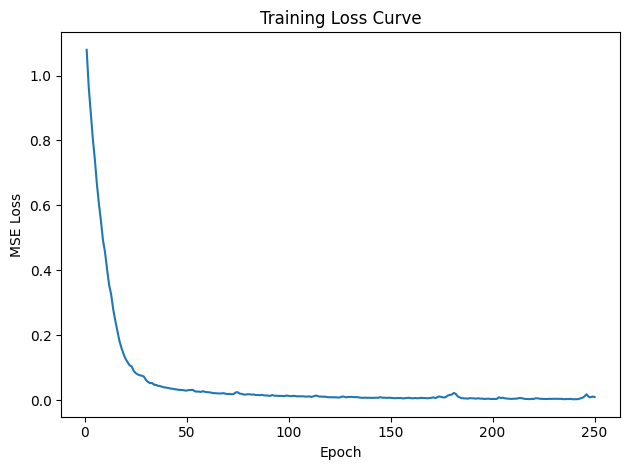

Fold 1 Training R²: 0.9872, Pearson r: 0.9954


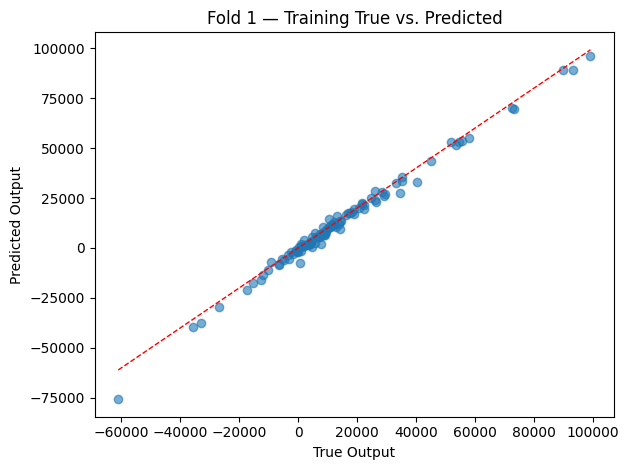

Fold 1 Validation MSE (norm): 0.3447
Fold 1 Validation R²: -0.7236, Pearson r: 0.4386


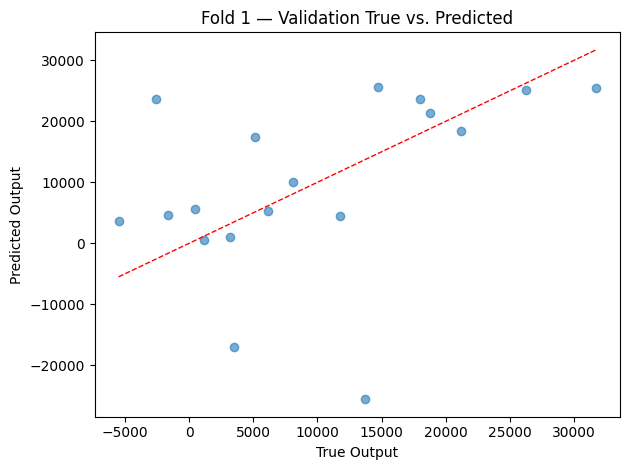


=== Fold 2/7 ===
Epoch   1/250  MSE=0.9329
Epoch  10/250  MSE=0.3225
Epoch  20/250  MSE=0.1086
Epoch  30/250  MSE=0.0507
Epoch  40/250  MSE=0.0327
Epoch  50/250  MSE=0.0269
Epoch  60/250  MSE=0.0287
Epoch  70/250  MSE=0.0207
Epoch  80/250  MSE=0.0195
Epoch  90/250  MSE=0.0154
Epoch 100/250  MSE=0.0150
Epoch 110/250  MSE=0.0130
Epoch 120/250  MSE=0.0113
Epoch 130/250  MSE=0.0098
Epoch 140/250  MSE=0.0082
Epoch 150/250  MSE=0.0083
Epoch 160/250  MSE=0.0069
Epoch 170/250  MSE=0.0120
Epoch 180/250  MSE=0.0065
Epoch 190/250  MSE=0.0060
Epoch 200/250  MSE=0.0063
Epoch 210/250  MSE=0.0076
Epoch 220/250  MSE=0.0061
Epoch 230/250  MSE=0.0053
Epoch 240/250  MSE=0.0056
Epoch 250/250  MSE=0.0088


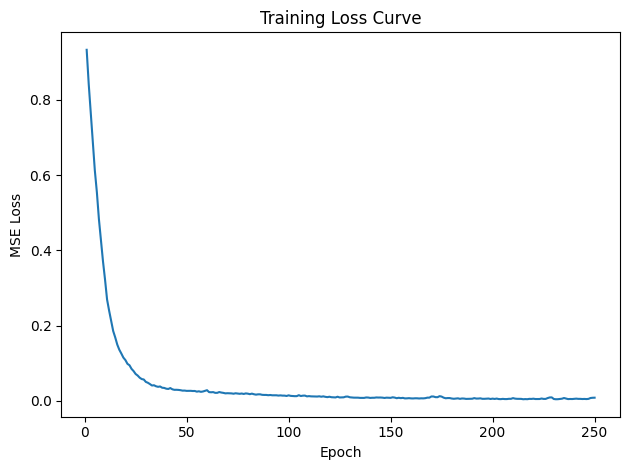

Fold 2 Training R²: 0.9948, Pearson r: 0.9975


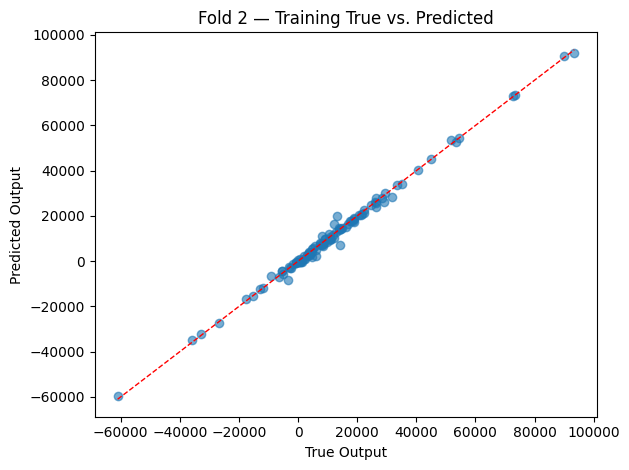

Fold 2 Validation MSE (norm): 0.2922
Fold 2 Validation R²: 0.7890, Pearson r: 0.8972


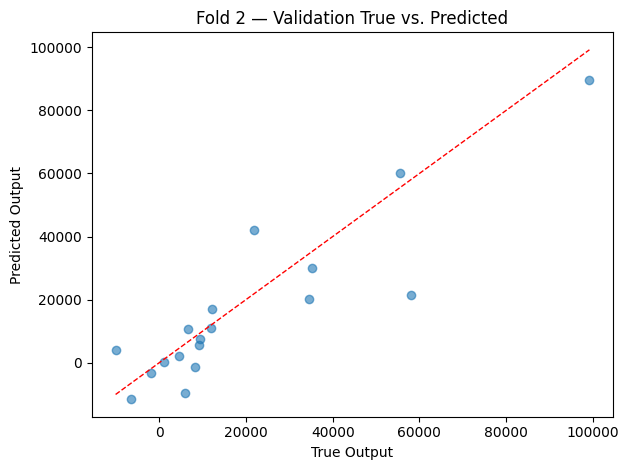


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0625
Epoch  10/250  MSE=0.3691
Epoch  20/250  MSE=0.0869
Epoch  30/250  MSE=0.0351
Epoch  40/250  MSE=0.0212
Epoch  50/250  MSE=0.0170
Epoch  60/250  MSE=0.0122
Epoch  70/250  MSE=0.0107
Epoch  80/250  MSE=0.0093
Epoch  90/250  MSE=0.0083
Epoch 100/250  MSE=0.0082
Epoch 110/250  MSE=0.0070
Epoch 120/250  MSE=0.0067
Epoch 130/250  MSE=0.0060
Epoch 140/250  MSE=0.0056
Epoch 150/250  MSE=0.0055
Epoch 160/250  MSE=0.0046
Epoch 170/250  MSE=0.0044
Epoch 180/250  MSE=0.0040
Epoch 190/250  MSE=0.0041
Epoch 200/250  MSE=0.0058
Epoch 210/250  MSE=0.0038
Epoch 220/250  MSE=0.0037
Epoch 230/250  MSE=0.0041
Epoch 240/250  MSE=0.0033
Epoch 250/250  MSE=0.0033


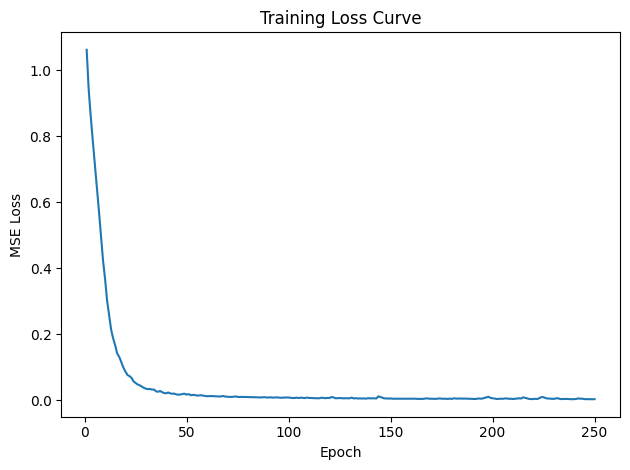

Fold 3 Training R²: 0.9974, Pearson r: 0.9987


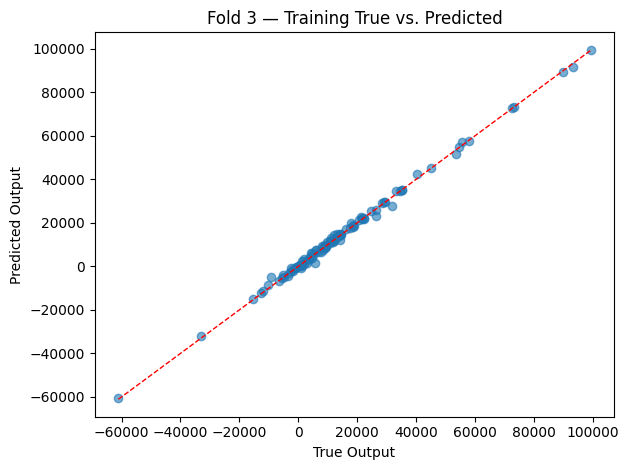

Fold 3 Validation MSE (norm): 0.2615
Fold 3 Validation R²: 0.6393, Pearson r: 0.9044


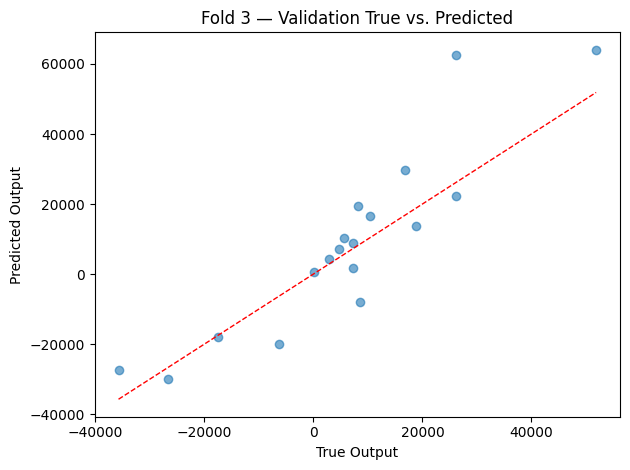


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8578
Epoch  10/250  MSE=0.3432
Epoch  20/250  MSE=0.0911
Epoch  30/250  MSE=0.0540
Epoch  40/250  MSE=0.0423
Epoch  50/250  MSE=0.0299
Epoch  60/250  MSE=0.0242
Epoch  70/250  MSE=0.0191
Epoch  80/250  MSE=0.0152
Epoch  90/250  MSE=0.0143
Epoch 100/250  MSE=0.0104
Epoch 110/250  MSE=0.0089
Epoch 120/250  MSE=0.0077
Epoch 130/250  MSE=0.0065
Epoch 140/250  MSE=0.0054
Epoch 150/250  MSE=0.0078
Epoch 160/250  MSE=0.0048
Epoch 170/250  MSE=0.0043
Epoch 180/250  MSE=0.0041
Epoch 190/250  MSE=0.0054
Epoch 200/250  MSE=0.0043
Epoch 210/250  MSE=0.0089
Epoch 220/250  MSE=0.0032
Epoch 230/250  MSE=0.0029
Epoch 240/250  MSE=0.0029
Epoch 250/250  MSE=0.0056


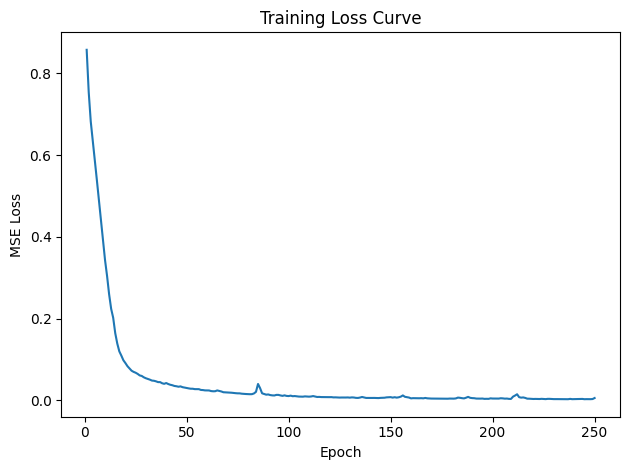

Fold 4 Training R²: 0.9949, Pearson r: 0.9977


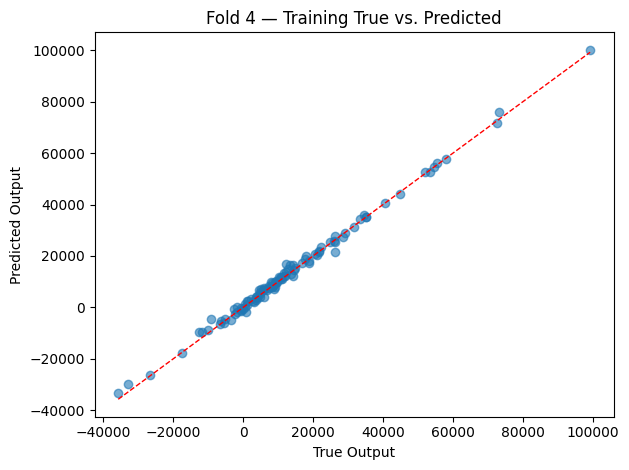

Fold 4 Validation MSE (norm): 1.1923
Fold 4 Validation R²: 0.4511, Pearson r: 0.6810


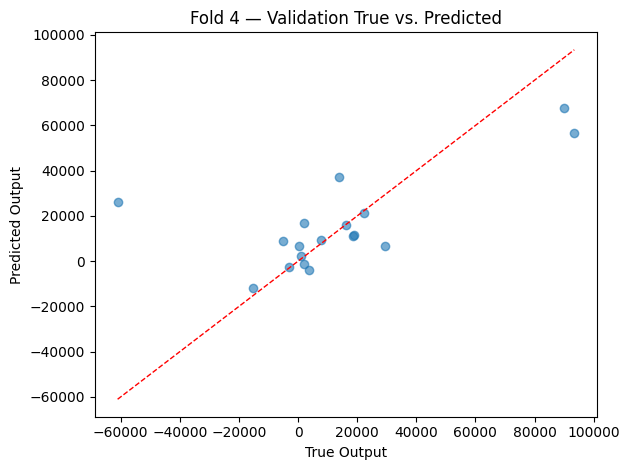


=== Fold 5/7 ===
Epoch   1/250  MSE=0.9997
Epoch  10/250  MSE=0.2577
Epoch  20/250  MSE=0.1039
Epoch  30/250  MSE=0.0652
Epoch  40/250  MSE=0.0485
Epoch  50/250  MSE=0.0373
Epoch  60/250  MSE=0.0313
Epoch  70/250  MSE=0.0269
Epoch  80/250  MSE=0.0246
Epoch  90/250  MSE=0.0205
Epoch 100/250  MSE=0.0163
Epoch 110/250  MSE=0.0149
Epoch 120/250  MSE=0.0131
Epoch 130/250  MSE=0.0124
Epoch 140/250  MSE=0.0105
Epoch 150/250  MSE=0.0096
Epoch 160/250  MSE=0.0073
Epoch 170/250  MSE=0.0077
Epoch 180/250  MSE=0.0065
Epoch 190/250  MSE=0.0120
Epoch 200/250  MSE=0.0058
Epoch 210/250  MSE=0.0058
Epoch 220/250  MSE=0.0043
Epoch 230/250  MSE=0.0034
Epoch 240/250  MSE=0.0043
Epoch 250/250  MSE=0.0033


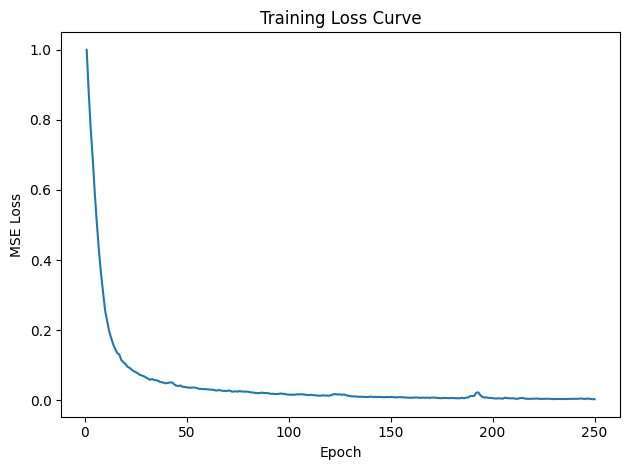

Fold 5 Training R²: 0.9972, Pearson r: 0.9986


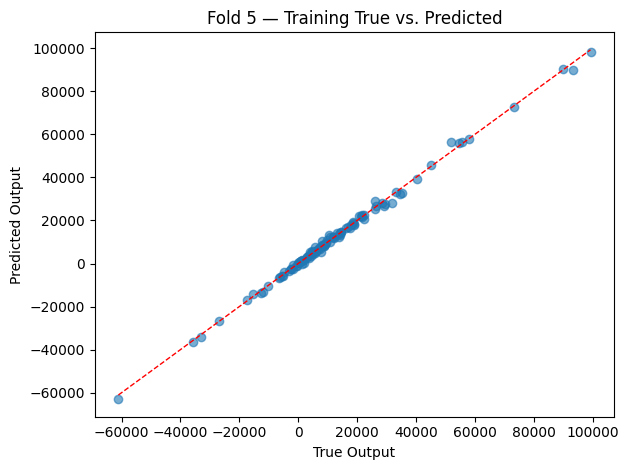

Fold 5 Validation MSE (norm): 0.6060
Fold 5 Validation R²: 0.2281, Pearson r: 0.8280


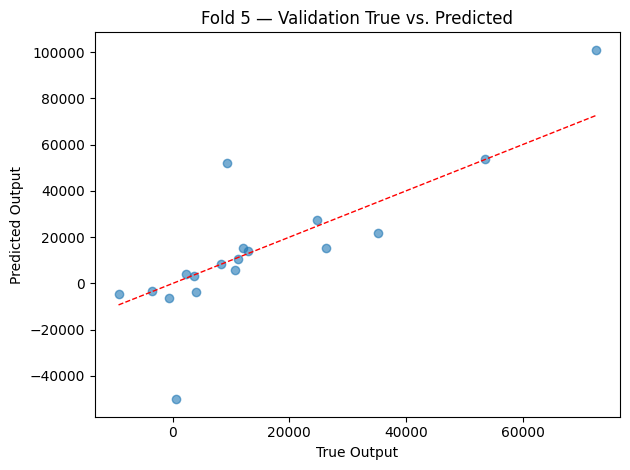


=== Fold 6/7 ===
Epoch   1/250  MSE=0.8873
Epoch  10/250  MSE=0.2239
Epoch  20/250  MSE=0.0835
Epoch  30/250  MSE=0.0546
Epoch  40/250  MSE=0.0391
Epoch  50/250  MSE=0.0314
Epoch  60/250  MSE=0.0282
Epoch  70/250  MSE=0.0233
Epoch  80/250  MSE=0.0197
Epoch  90/250  MSE=0.0164
Epoch 100/250  MSE=0.0132
Epoch 110/250  MSE=0.0107
Epoch 120/250  MSE=0.0091
Epoch 130/250  MSE=0.0083
Epoch 140/250  MSE=0.0121
Epoch 150/250  MSE=0.0048
Epoch 160/250  MSE=0.0045
Epoch 170/250  MSE=0.0040
Epoch 180/250  MSE=0.0038
Epoch 190/250  MSE=0.0030
Epoch 200/250  MSE=0.0031
Epoch 210/250  MSE=0.0074
Epoch 220/250  MSE=0.0018
Epoch 230/250  MSE=0.0017
Epoch 240/250  MSE=0.0068
Epoch 250/250  MSE=0.0014


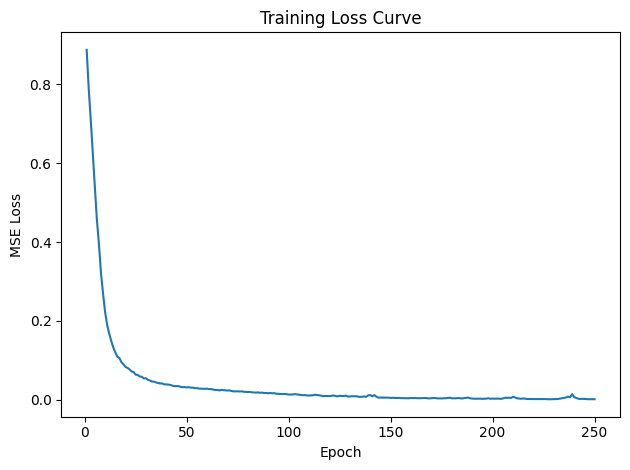

Fold 6 Training R²: 0.9988, Pearson r: 0.9994


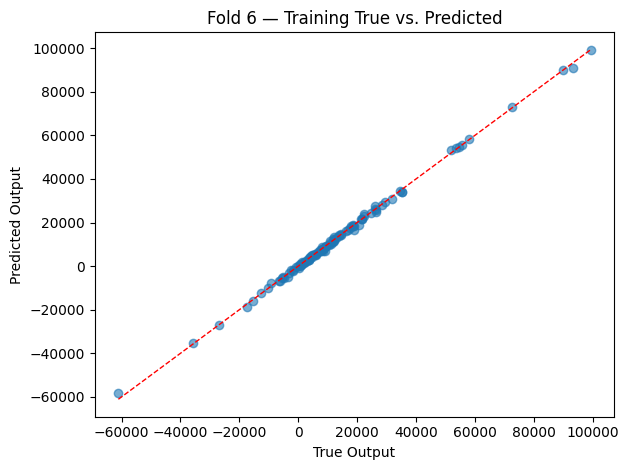

Fold 6 Validation MSE (norm): 1.1138
Fold 6 Validation R²: -0.0422, Pearson r: 0.5349


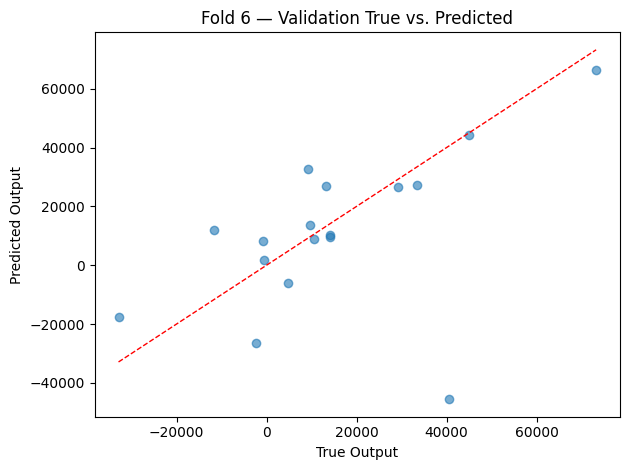


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1334
Epoch  10/250  MSE=0.3601
Epoch  20/250  MSE=0.1351
Epoch  30/250  MSE=0.0815
Epoch  40/250  MSE=0.0527
Epoch  50/250  MSE=0.0370
Epoch  60/250  MSE=0.0293
Epoch  70/250  MSE=0.0232
Epoch  80/250  MSE=0.0202
Epoch  90/250  MSE=0.0189
Epoch 100/250  MSE=0.0152
Epoch 110/250  MSE=0.0142
Epoch 120/250  MSE=0.0120
Epoch 130/250  MSE=0.0103
Epoch 140/250  MSE=0.0094
Epoch 150/250  MSE=0.0090
Epoch 160/250  MSE=0.0064
Epoch 170/250  MSE=0.0106
Epoch 180/250  MSE=0.0061
Epoch 190/250  MSE=0.0057
Epoch 200/250  MSE=0.0126
Epoch 210/250  MSE=0.0054
Epoch 220/250  MSE=0.0041
Epoch 230/250  MSE=0.0040
Epoch 240/250  MSE=0.0056
Epoch 250/250  MSE=0.0042


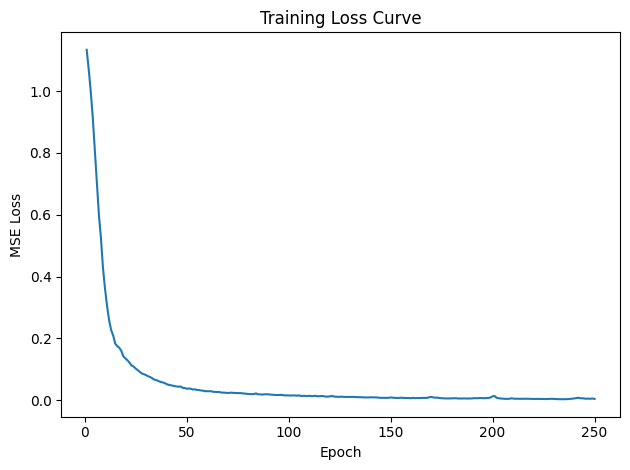

Fold 7 Training R²: 0.9962, Pearson r: 0.9982


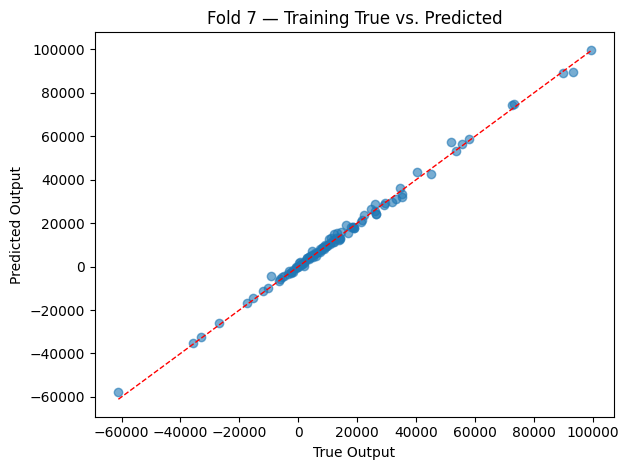

Fold 7 Validation MSE (norm): 0.1576
Fold 7 Validation R²: 0.6245, Pearson r: 0.8129


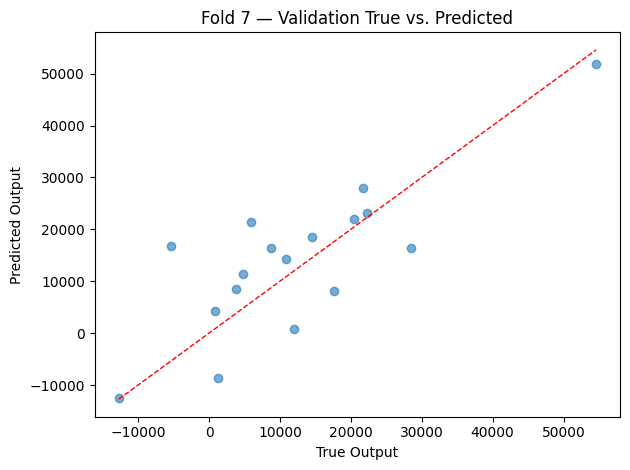


=== Validation MSE per fold ===
['0.3447', '0.2922', '0.2615', '1.1923', '0.6060', '1.1138', '0.1576']
Mean MSE (norm): 0.5669 ± 0.3923

=== Validation R² per fold ===
['-0.7236', '0.7890', '0.6393', '0.4511', '0.2281', '-0.0422', '0.6245']
Mean R²: 0.2809 ± 0.4855

=== Validation Pearson r per fold ===
['0.4386', '0.8972', '0.9044', '0.6810', '0.8280', '0.5349', '0.8129']
Mean Pearson r: 0.7281 ± 0.1691


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [42]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [12],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [16] linear


=== Fold 1/7 ===
Epoch   1/250  MSE=1.0883
Epoch  10/250  MSE=0.2168
Epoch  20/250  MSE=0.1414
Epoch  30/250  MSE=0.1180
Epoch  40/250  MSE=0.1095
Epoch  50/250  MSE=0.1014
Epoch  60/250  MSE=0.0962
Epoch  70/250  MSE=0.0968
Epoch  80/250  MSE=0.0941
Epoch  90/250  MSE=0.0915
Epoch 100/250  MSE=0.0908
Epoch 110/250  MSE=0.0840
Epoch 120/250  MSE=0.0833
Epoch 130/250  MSE=0.0841
Epoch 140/250  MSE=0.0863
Epoch 150/250  MSE=0.0851
Epoch 160/250  MSE=0.0820
Epoch 170/250  MSE=0.0817
Epoch 180/250  MSE=0.0835
Epoch 190/250  MSE=0.0812
Epoch 200/250  MSE=0.0838
Epoch 210/250  MSE=0.0774
Epoch 220/250  MSE=0.0782
Epoch 230/250  MSE=0.0785
Epoch 240/250  MSE=0.0809
Epoch 250/250  MSE=0.0845


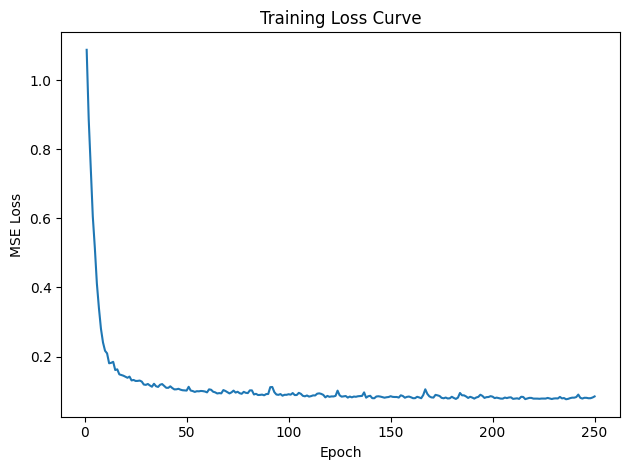

Fold 1 Training R²: 0.9322, Pearson r: 0.9663


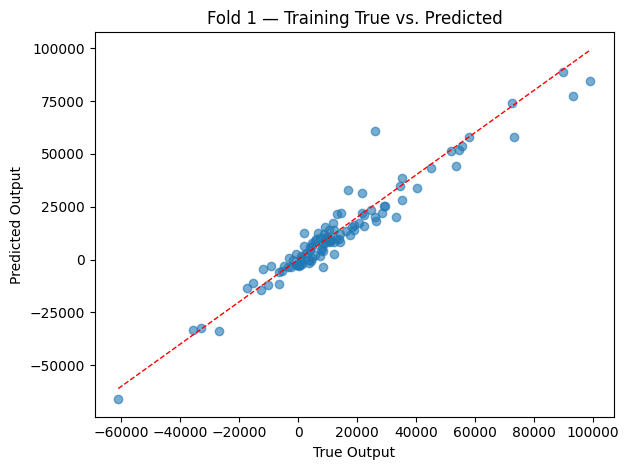

Fold 1 Validation MSE (norm): 0.1773
Fold 1 Validation R²: 0.1132, Pearson r: 0.6625


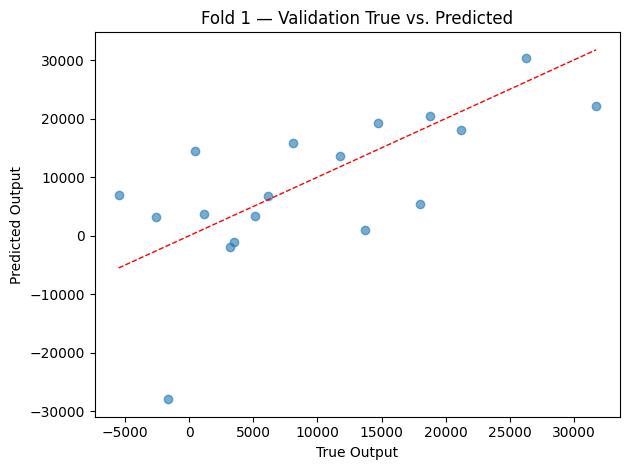


=== Fold 2/7 ===
Epoch   1/250  MSE=0.8279
Epoch  10/250  MSE=0.1924
Epoch  20/250  MSE=0.1309
Epoch  30/250  MSE=0.1137
Epoch  40/250  MSE=0.1111
Epoch  50/250  MSE=0.1016
Epoch  60/250  MSE=0.1036
Epoch  70/250  MSE=0.0961
Epoch  80/250  MSE=0.0956
Epoch  90/250  MSE=0.0886
Epoch 100/250  MSE=0.0878
Epoch 110/250  MSE=0.0968
Epoch 120/250  MSE=0.0837
Epoch 130/250  MSE=0.0901
Epoch 140/250  MSE=0.0795
Epoch 150/250  MSE=0.0842
Epoch 160/250  MSE=0.0824
Epoch 170/250  MSE=0.0813
Epoch 180/250  MSE=0.0949
Epoch 190/250  MSE=0.0773
Epoch 200/250  MSE=0.0791
Epoch 210/250  MSE=0.0761
Epoch 220/250  MSE=0.0782
Epoch 230/250  MSE=0.0744
Epoch 240/250  MSE=0.0764
Epoch 250/250  MSE=0.0972


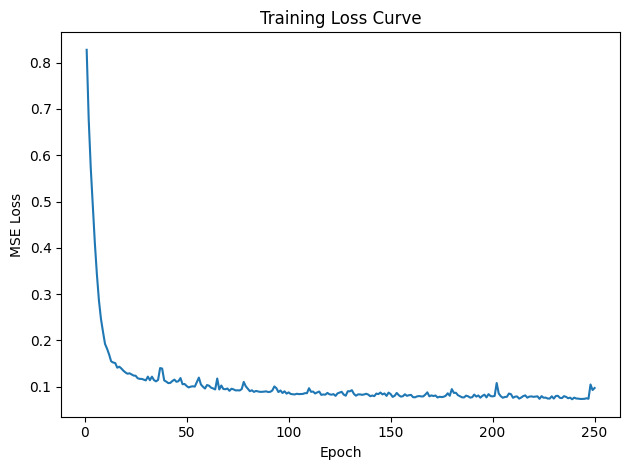

Fold 2 Training R²: 0.9207, Pearson r: 0.9606


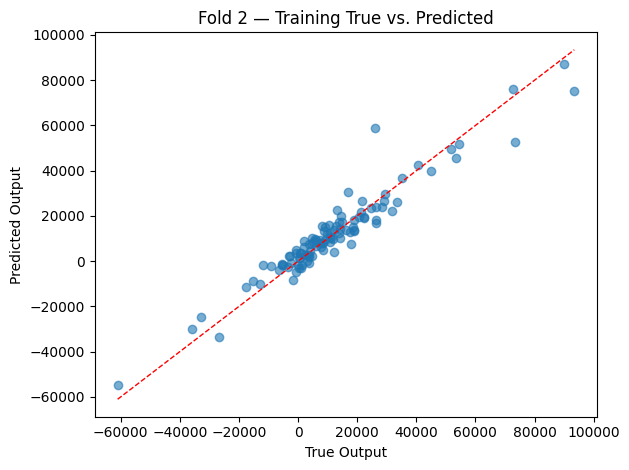

Fold 2 Validation MSE (norm): 0.1833
Fold 2 Validation R²: 0.8677, Pearson r: 0.9320


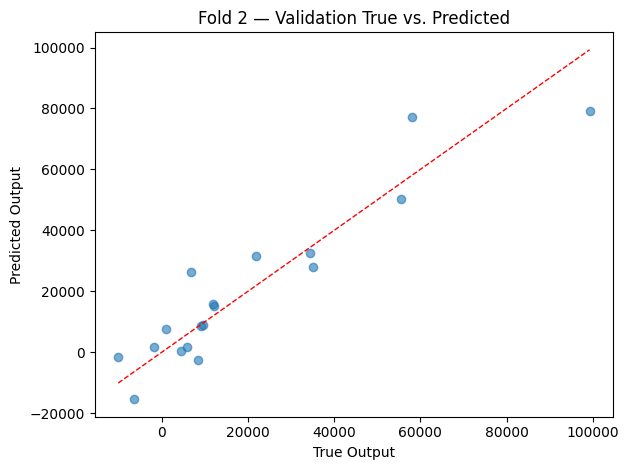


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0346
Epoch  10/250  MSE=0.2064
Epoch  20/250  MSE=0.1177
Epoch  30/250  MSE=0.0858
Epoch  40/250  MSE=0.0742
Epoch  50/250  MSE=0.0652
Epoch  60/250  MSE=0.0643
Epoch  70/250  MSE=0.0598
Epoch  80/250  MSE=0.0564
Epoch  90/250  MSE=0.0550
Epoch 100/250  MSE=0.0633
Epoch 110/250  MSE=0.0600
Epoch 120/250  MSE=0.0524
Epoch 130/250  MSE=0.0588
Epoch 140/250  MSE=0.0580
Epoch 150/250  MSE=0.0504
Epoch 160/250  MSE=0.0519
Epoch 170/250  MSE=0.0512
Epoch 180/250  MSE=0.0519
Epoch 190/250  MSE=0.0519
Epoch 200/250  MSE=0.0498
Epoch 210/250  MSE=0.0500
Epoch 220/250  MSE=0.0534
Epoch 230/250  MSE=0.0512
Epoch 240/250  MSE=0.0529
Epoch 250/250  MSE=0.0504


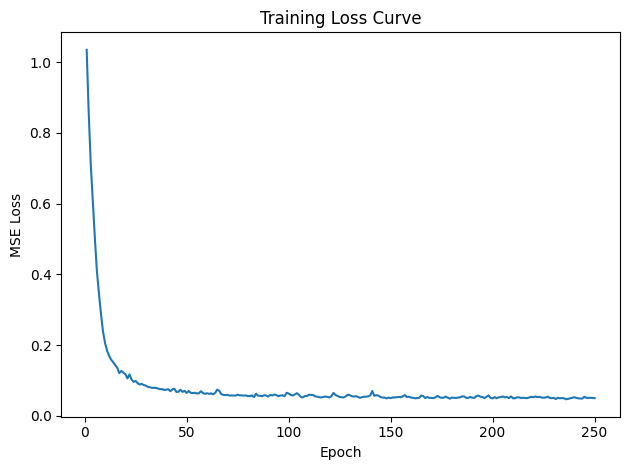

Fold 3 Training R²: 0.9554, Pearson r: 0.9779


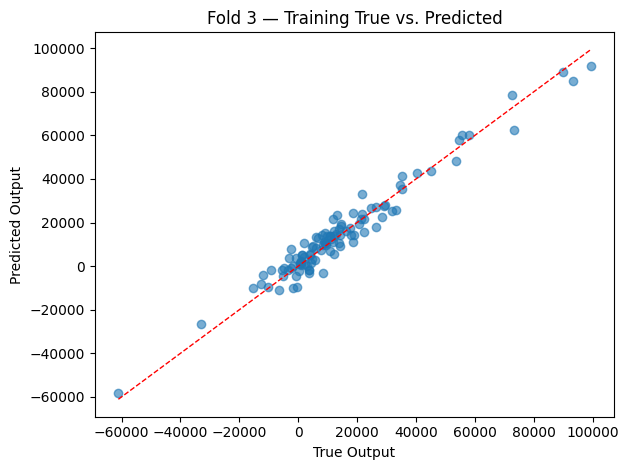

Fold 3 Validation MSE (norm): 0.3123
Fold 3 Validation R²: 0.5692, Pearson r: 0.9121


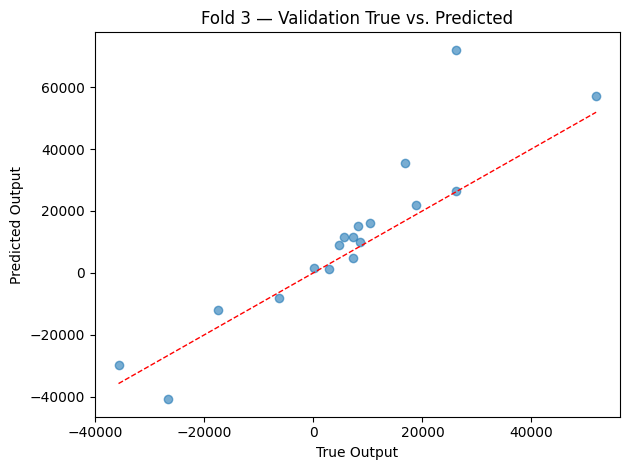


=== Fold 4/7 ===
Epoch   1/250  MSE=0.7496
Epoch  10/250  MSE=0.1378
Epoch  20/250  MSE=0.0890
Epoch  30/250  MSE=0.0798
Epoch  40/250  MSE=0.0777
Epoch  50/250  MSE=0.0798
Epoch  60/250  MSE=0.0747
Epoch  70/250  MSE=0.0750
Epoch  80/250  MSE=0.0740
Epoch  90/250  MSE=0.0734
Epoch 100/250  MSE=0.0776
Epoch 110/250  MSE=0.0763
Epoch 120/250  MSE=0.0722
Epoch 130/250  MSE=0.0711
Epoch 140/250  MSE=0.0719
Epoch 150/250  MSE=0.0720
Epoch 160/250  MSE=0.0702
Epoch 170/250  MSE=0.0746
Epoch 180/250  MSE=0.0747
Epoch 190/250  MSE=0.0838
Epoch 200/250  MSE=0.0757
Epoch 210/250  MSE=0.0704
Epoch 220/250  MSE=0.0767
Epoch 230/250  MSE=0.0713
Epoch 240/250  MSE=0.0704
Epoch 250/250  MSE=0.0733


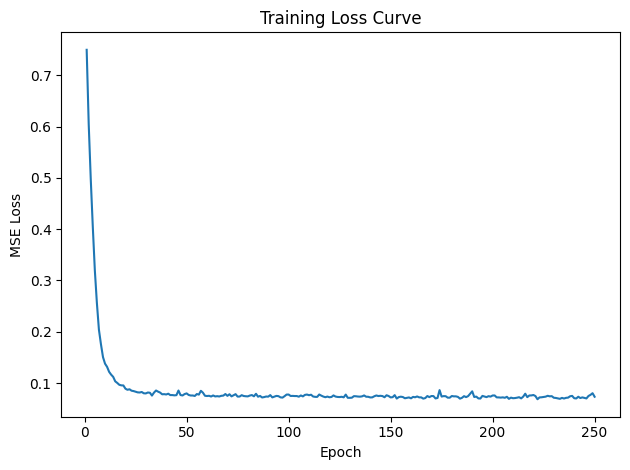

Fold 4 Training R²: 0.9126, Pearson r: 0.9559


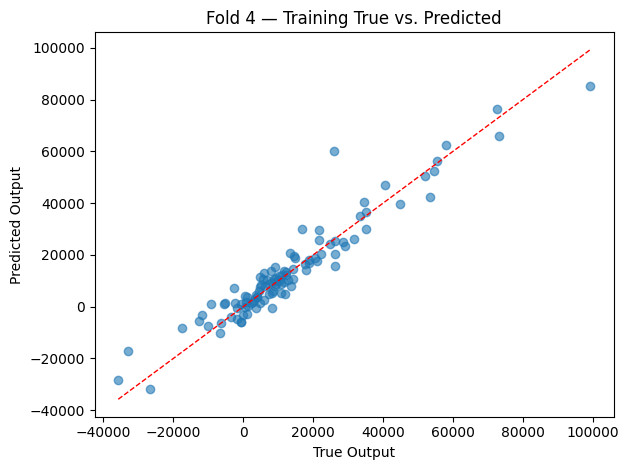

Fold 4 Validation MSE (norm): 1.2542
Fold 4 Validation R²: 0.4226, Pearson r: 0.6764


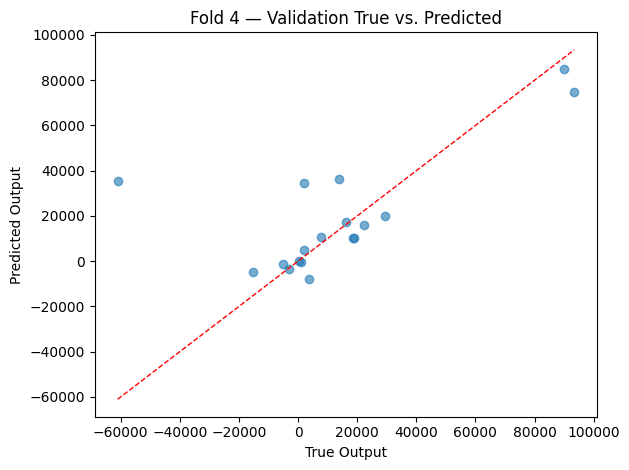


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0775
Epoch  10/250  MSE=0.2542
Epoch  20/250  MSE=0.1425
Epoch  30/250  MSE=0.1265
Epoch  40/250  MSE=0.1159
Epoch  50/250  MSE=0.1064
Epoch  60/250  MSE=0.1018
Epoch  70/250  MSE=0.0987
Epoch  80/250  MSE=0.0944
Epoch  90/250  MSE=0.0952
Epoch 100/250  MSE=0.0882
Epoch 110/250  MSE=0.0924
Epoch 120/250  MSE=0.0920
Epoch 130/250  MSE=0.0855
Epoch 140/250  MSE=0.0894
Epoch 150/250  MSE=0.0845
Epoch 160/250  MSE=0.0835
Epoch 170/250  MSE=0.0862
Epoch 180/250  MSE=0.0874
Epoch 190/250  MSE=0.0885
Epoch 200/250  MSE=0.0787
Epoch 210/250  MSE=0.0831
Epoch 220/250  MSE=0.0803
Epoch 230/250  MSE=0.0809
Epoch 240/250  MSE=0.0818
Epoch 250/250  MSE=0.0792


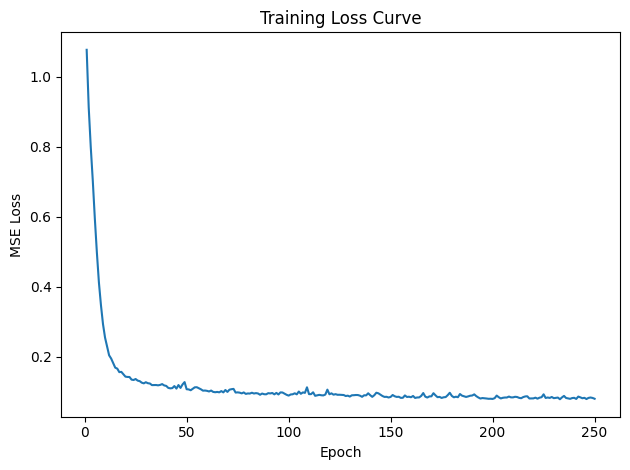

Fold 5 Training R²: 0.9277, Pearson r: 0.9633


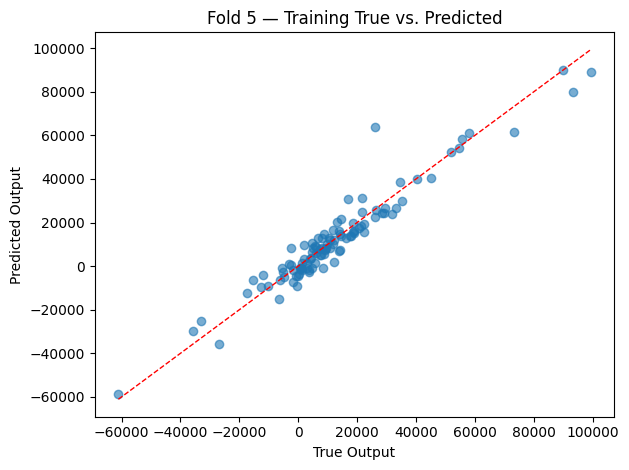

Fold 5 Validation MSE (norm): 0.2167
Fold 5 Validation R²: 0.7239, Pearson r: 0.9220


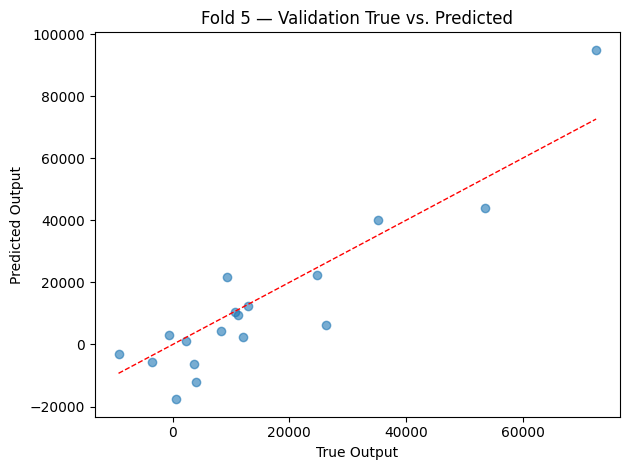


=== Fold 6/7 ===
Epoch   1/250  MSE=0.9764
Epoch  10/250  MSE=0.1807
Epoch  20/250  MSE=0.1158
Epoch  30/250  MSE=0.0908
Epoch  40/250  MSE=0.0890
Epoch  50/250  MSE=0.0794
Epoch  60/250  MSE=0.0825
Epoch  70/250  MSE=0.0749
Epoch  80/250  MSE=0.0715
Epoch  90/250  MSE=0.0729
Epoch 100/250  MSE=0.0739
Epoch 110/250  MSE=0.0715
Epoch 120/250  MSE=0.0697
Epoch 130/250  MSE=0.0720
Epoch 140/250  MSE=0.0696
Epoch 150/250  MSE=0.0681
Epoch 160/250  MSE=0.0702
Epoch 170/250  MSE=0.0681
Epoch 180/250  MSE=0.0790
Epoch 190/250  MSE=0.0680
Epoch 200/250  MSE=0.0663
Epoch 210/250  MSE=0.0670
Epoch 220/250  MSE=0.0681
Epoch 230/250  MSE=0.0712
Epoch 240/250  MSE=0.0696
Epoch 250/250  MSE=0.0713


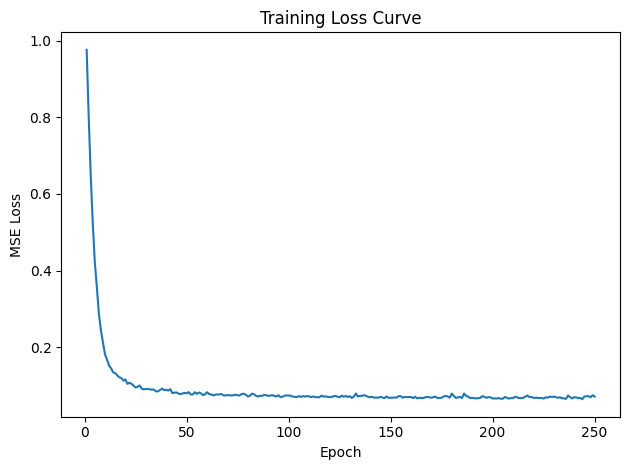

Fold 6 Training R²: 0.9344, Pearson r: 0.9672


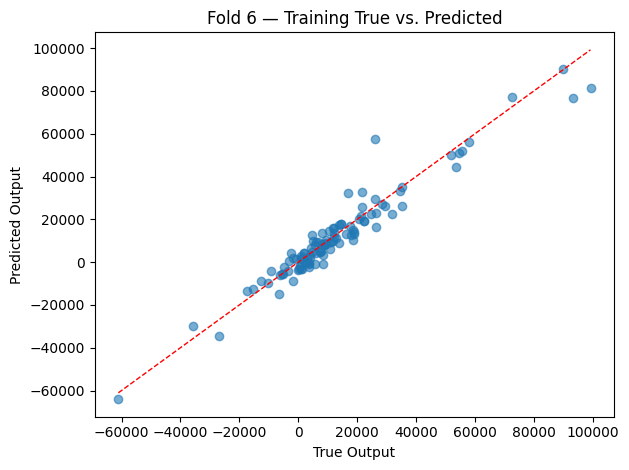

Fold 6 Validation MSE (norm): 1.1288
Fold 6 Validation R²: -0.0563, Pearson r: 0.4937


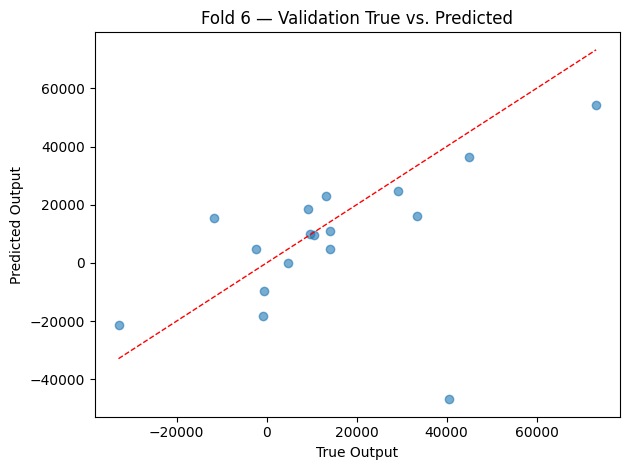


=== Fold 7/7 ===
Epoch   1/250  MSE=1.1239
Epoch  10/250  MSE=0.2717
Epoch  20/250  MSE=0.1558
Epoch  30/250  MSE=0.1243
Epoch  40/250  MSE=0.1145
Epoch  50/250  MSE=0.1056
Epoch  60/250  MSE=0.0970
Epoch  70/250  MSE=0.0959
Epoch  80/250  MSE=0.0939
Epoch  90/250  MSE=0.0969
Epoch 100/250  MSE=0.0893
Epoch 110/250  MSE=0.0880
Epoch 120/250  MSE=0.0840
Epoch 130/250  MSE=0.0836
Epoch 140/250  MSE=0.0809
Epoch 150/250  MSE=0.0817
Epoch 160/250  MSE=0.0826
Epoch 170/250  MSE=0.0782
Epoch 180/250  MSE=0.0808
Epoch 190/250  MSE=0.0799
Epoch 200/250  MSE=0.0846
Epoch 210/250  MSE=0.0803
Epoch 220/250  MSE=0.0822
Epoch 230/250  MSE=0.0804
Epoch 240/250  MSE=0.0773
Epoch 250/250  MSE=0.0818


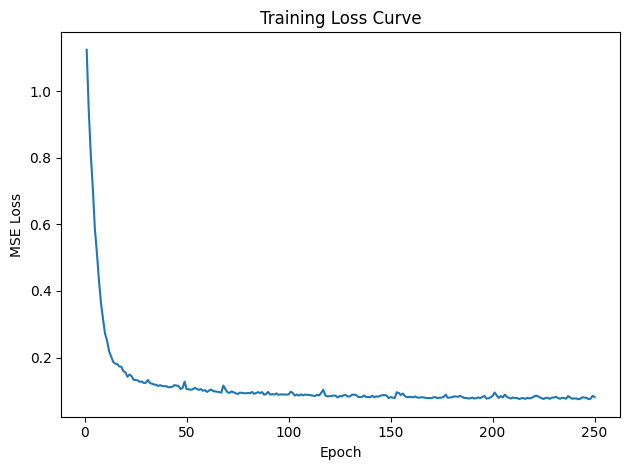

Fold 7 Training R²: 0.9336, Pearson r: 0.9663


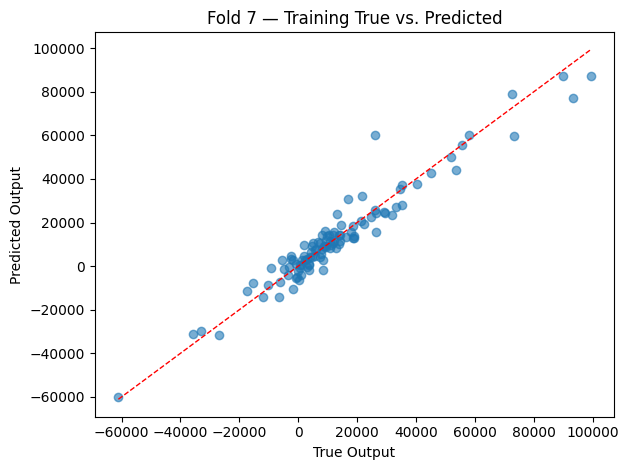

Fold 7 Validation MSE (norm): 0.2592
Fold 7 Validation R²: 0.3823, Pearson r: 0.7376


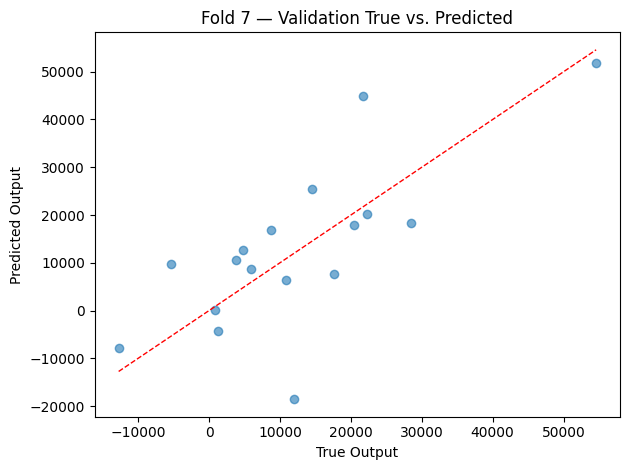


=== Validation MSE per fold ===
['0.1773', '0.1833', '0.3123', '1.2542', '0.2167', '1.1288', '0.2592']
Mean MSE (norm): 0.5045 ± 0.4379

=== Validation R² per fold ===
['0.1132', '0.8677', '0.5692', '0.4226', '0.7239', '-0.0563', '0.3823']
Mean R²: 0.4318 ± 0.3015

=== Validation Pearson r per fold ===
['0.6625', '0.9320', '0.9121', '0.6764', '0.9220', '0.4937', '0.7376']
Mean Pearson r: 0.7623 ± 0.1544


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [43]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [16],
    'activation':  'linear',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [8,8] linear


=== Fold 1/7 ===
Epoch   1/250  MSE=1.1926
Epoch  10/250  MSE=0.2416
Epoch  20/250  MSE=0.1459
Epoch  30/250  MSE=0.1251
Epoch  40/250  MSE=0.1244
Epoch  50/250  MSE=0.1210
Epoch  60/250  MSE=0.1079
Epoch  70/250  MSE=0.0995
Epoch  80/250  MSE=0.0980
Epoch  90/250  MSE=0.0974
Epoch 100/250  MSE=0.0899
Epoch 110/250  MSE=0.1018
Epoch 120/250  MSE=0.0918
Epoch 130/250  MSE=0.0875
Epoch 140/250  MSE=0.0893
Epoch 150/250  MSE=0.0808
Epoch 160/250  MSE=0.0845
Epoch 170/250  MSE=0.0828
Epoch 180/250  MSE=0.0851
Epoch 190/250  MSE=0.0860
Epoch 200/250  MSE=0.1003
Epoch 210/250  MSE=0.0816
Epoch 220/250  MSE=0.0874
Epoch 230/250  MSE=0.0811
Epoch 240/250  MSE=0.0784
Epoch 250/250  MSE=0.0863


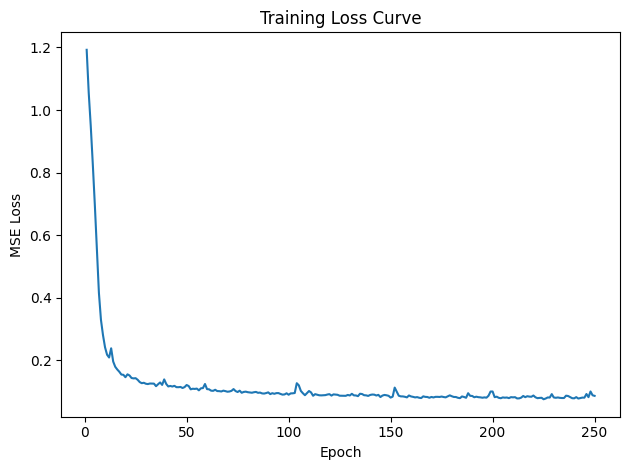

Fold 1 Training R²: 0.9316, Pearson r: 0.9661


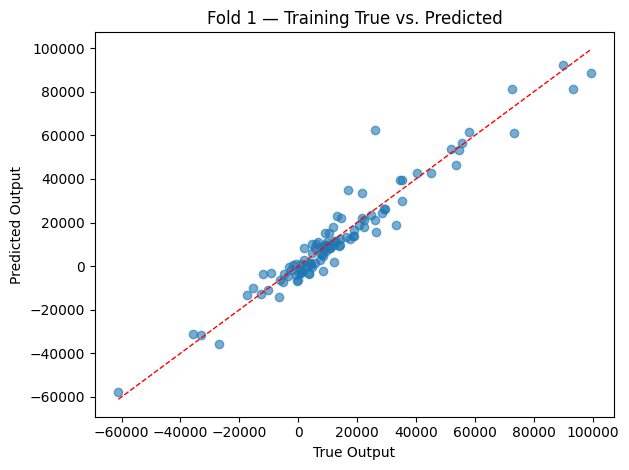

Fold 1 Validation MSE (norm): 0.1374
Fold 1 Validation R²: 0.3130, Pearson r: 0.7260


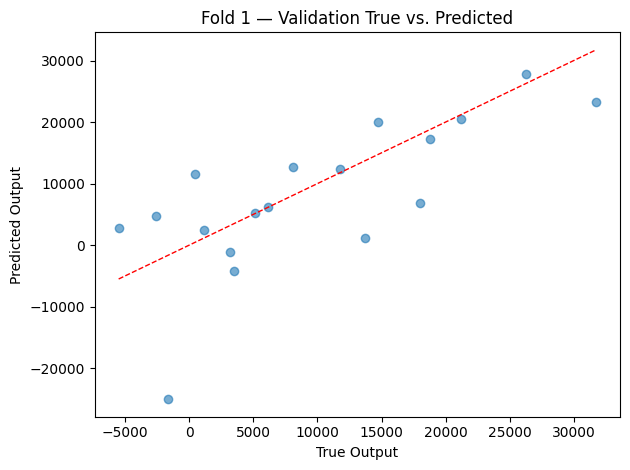


=== Fold 2/7 ===
Epoch   1/250  MSE=0.8957
Epoch  10/250  MSE=0.2285
Epoch  20/250  MSE=0.1429
Epoch  30/250  MSE=0.1243
Epoch  40/250  MSE=0.1209
Epoch  50/250  MSE=0.1155
Epoch  60/250  MSE=0.0948
Epoch  70/250  MSE=0.1054
Epoch  80/250  MSE=0.0931
Epoch  90/250  MSE=0.0950
Epoch 100/250  MSE=0.0875
Epoch 110/250  MSE=0.0837
Epoch 120/250  MSE=0.1111
Epoch 130/250  MSE=0.0825
Epoch 140/250  MSE=0.1049
Epoch 150/250  MSE=0.0807
Epoch 160/250  MSE=0.0787
Epoch 170/250  MSE=0.0833
Epoch 180/250  MSE=0.0794
Epoch 190/250  MSE=0.0771
Epoch 200/250  MSE=0.0767
Epoch 210/250  MSE=0.0834
Epoch 220/250  MSE=0.0797
Epoch 230/250  MSE=0.0732
Epoch 240/250  MSE=0.0751
Epoch 250/250  MSE=0.0738


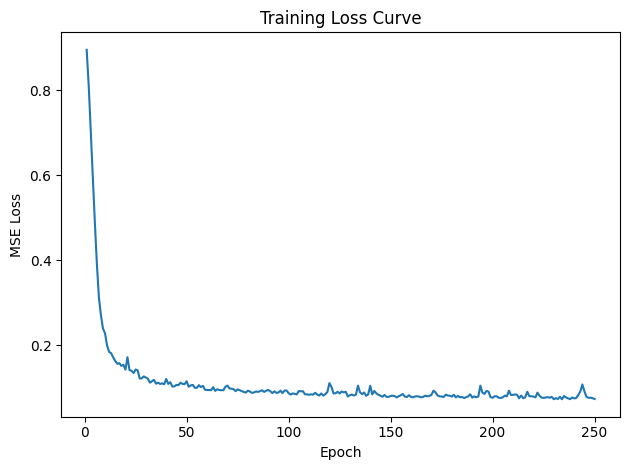

Fold 2 Training R²: 0.9233, Pearson r: 0.9613


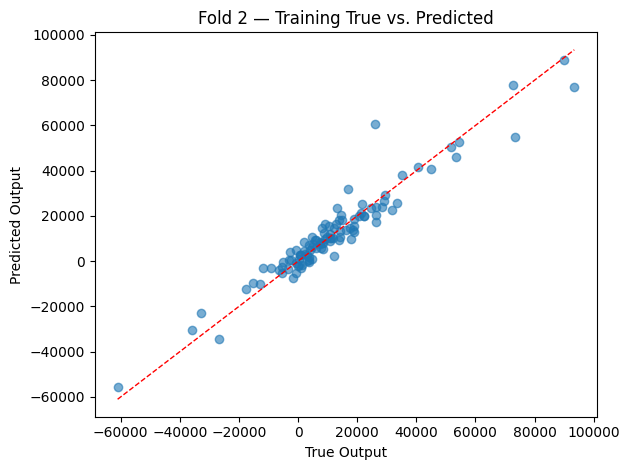

Fold 2 Validation MSE (norm): 0.1699
Fold 2 Validation R²: 0.8773, Pearson r: 0.9384


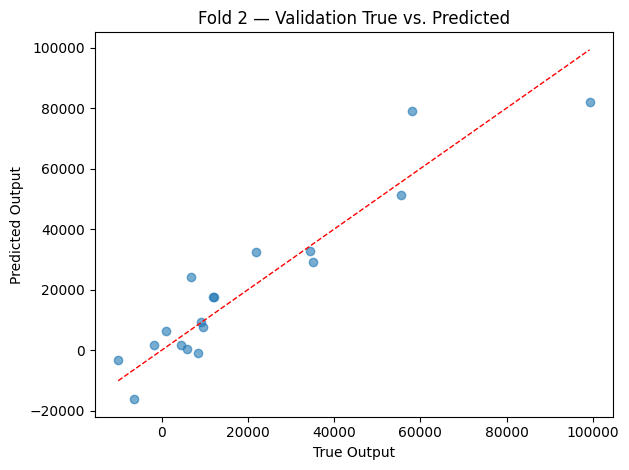


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0924
Epoch  10/250  MSE=0.2603
Epoch  20/250  MSE=0.1189
Epoch  30/250  MSE=0.0824
Epoch  40/250  MSE=0.0710
Epoch  50/250  MSE=0.0639
Epoch  60/250  MSE=0.0633
Epoch  70/250  MSE=0.0685
Epoch  80/250  MSE=0.0543
Epoch  90/250  MSE=0.0547
Epoch 100/250  MSE=0.0547
Epoch 110/250  MSE=0.0524
Epoch 120/250  MSE=0.0519
Epoch 130/250  MSE=0.0526
Epoch 140/250  MSE=0.0534
Epoch 150/250  MSE=0.0508
Epoch 160/250  MSE=0.0641
Epoch 170/250  MSE=0.0517
Epoch 180/250  MSE=0.0497
Epoch 190/250  MSE=0.0501
Epoch 200/250  MSE=0.0483
Epoch 210/250  MSE=0.0507
Epoch 220/250  MSE=0.0507
Epoch 230/250  MSE=0.0566
Epoch 240/250  MSE=0.0511
Epoch 250/250  MSE=0.0496


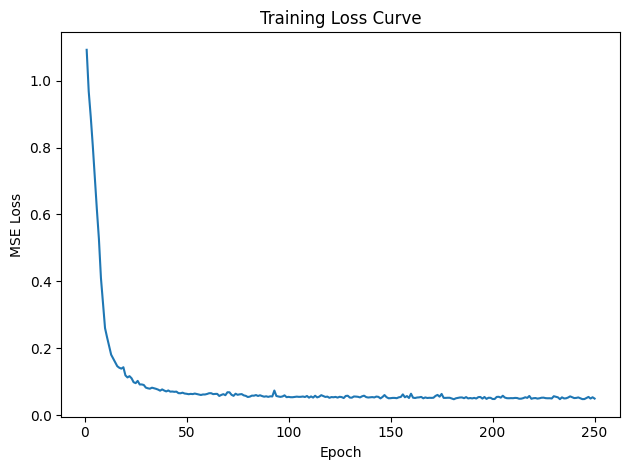

Fold 3 Training R²: 0.9552, Pearson r: 0.9780


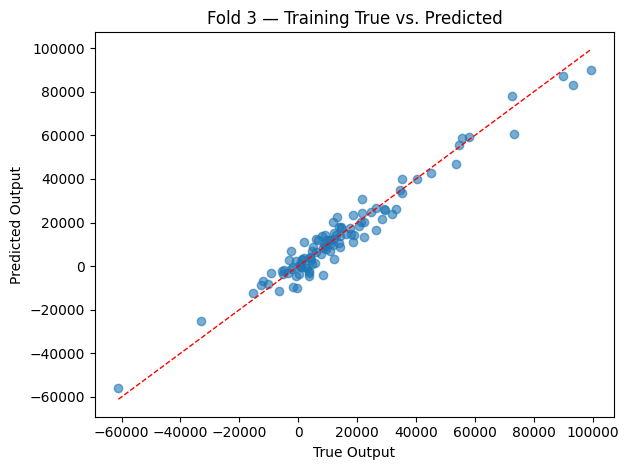

Fold 3 Validation MSE (norm): 0.2771
Fold 3 Validation R²: 0.6177, Pearson r: 0.9125


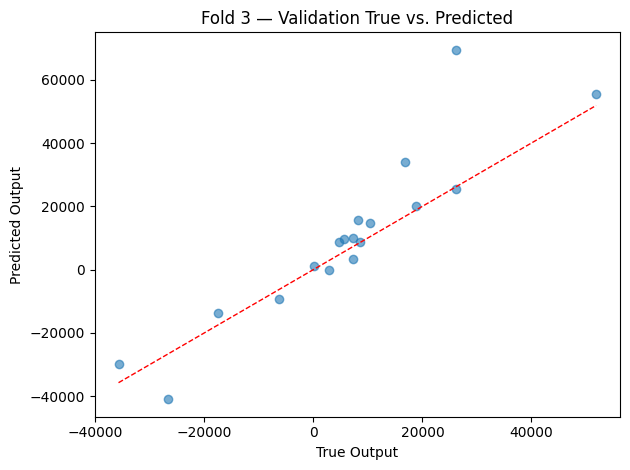


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8611
Epoch  10/250  MSE=0.1867
Epoch  20/250  MSE=0.0917
Epoch  30/250  MSE=0.0911
Epoch  40/250  MSE=0.0794
Epoch  50/250  MSE=0.0785
Epoch  60/250  MSE=0.0744
Epoch  70/250  MSE=0.0766
Epoch  80/250  MSE=0.0740
Epoch  90/250  MSE=0.0764
Epoch 100/250  MSE=0.0733
Epoch 110/250  MSE=0.0722
Epoch 120/250  MSE=0.0717
Epoch 130/250  MSE=0.0731
Epoch 140/250  MSE=0.0735
Epoch 150/250  MSE=0.0723
Epoch 160/250  MSE=0.0727
Epoch 170/250  MSE=0.0715
Epoch 180/250  MSE=0.0773
Epoch 190/250  MSE=0.0729
Epoch 200/250  MSE=0.0789
Epoch 210/250  MSE=0.0713
Epoch 220/250  MSE=0.0711
Epoch 230/250  MSE=0.0699
Epoch 240/250  MSE=0.0700
Epoch 250/250  MSE=0.0705


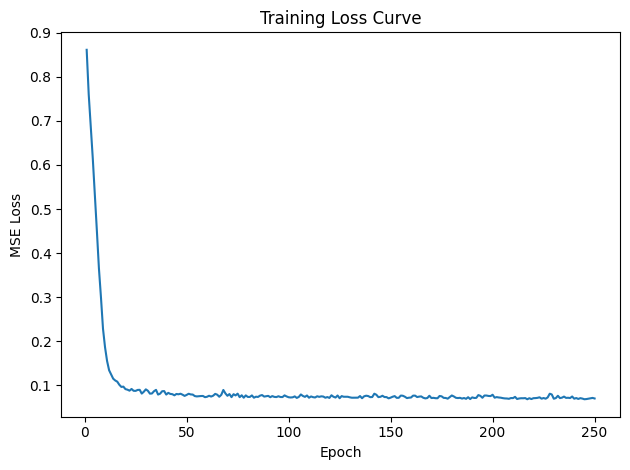

Fold 4 Training R²: 0.9171, Pearson r: 0.9578


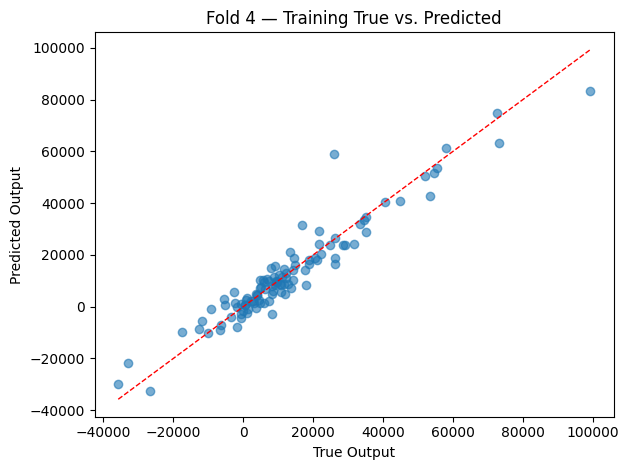

Fold 4 Validation MSE (norm): 1.0985
Fold 4 Validation R²: 0.4943, Pearson r: 0.7169


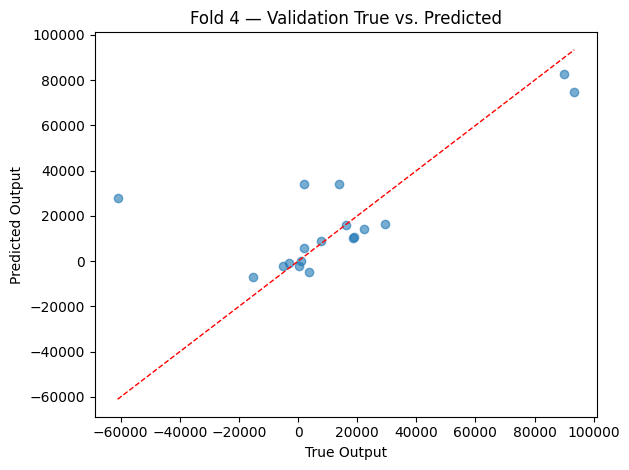


=== Fold 5/7 ===
Epoch   1/250  MSE=1.2030
Epoch  10/250  MSE=0.2737
Epoch  20/250  MSE=0.1475
Epoch  30/250  MSE=0.1335
Epoch  40/250  MSE=0.1137
Epoch  50/250  MSE=0.1180
Epoch  60/250  MSE=0.0988
Epoch  70/250  MSE=0.1025
Epoch  80/250  MSE=0.0989
Epoch  90/250  MSE=0.0947
Epoch 100/250  MSE=0.1064
Epoch 110/250  MSE=0.1080
Epoch 120/250  MSE=0.0887
Epoch 130/250  MSE=0.0900
Epoch 140/250  MSE=0.0908
Epoch 150/250  MSE=0.0876
Epoch 160/250  MSE=0.0936
Epoch 170/250  MSE=0.0866
Epoch 180/250  MSE=0.1056
Epoch 190/250  MSE=0.0842
Epoch 200/250  MSE=0.0866
Epoch 210/250  MSE=0.0839
Epoch 220/250  MSE=0.0917
Epoch 230/250  MSE=0.0855
Epoch 240/250  MSE=0.0878
Epoch 250/250  MSE=0.0798


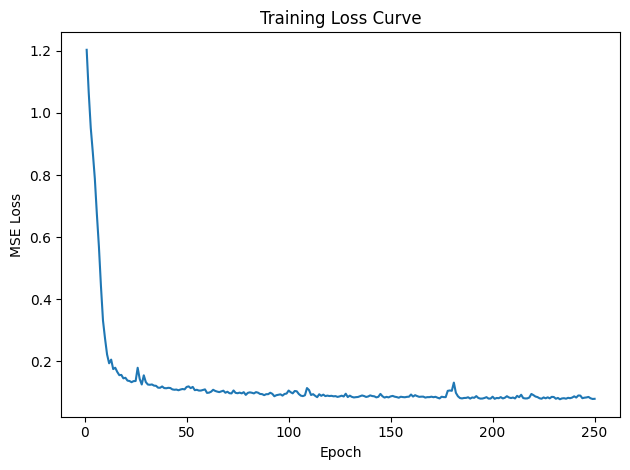

Fold 5 Training R²: 0.9279, Pearson r: 0.9634


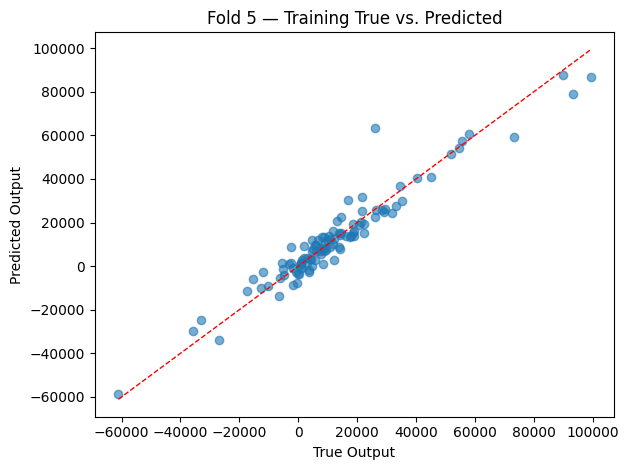

Fold 5 Validation MSE (norm): 0.2029
Fold 5 Validation R²: 0.7415, Pearson r: 0.9202


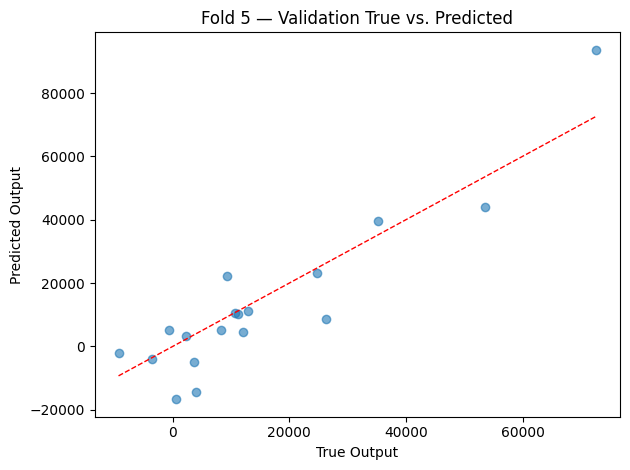


=== Fold 6/7 ===
Epoch   1/250  MSE=1.0583
Epoch  10/250  MSE=0.1945
Epoch  20/250  MSE=0.1090
Epoch  30/250  MSE=0.1006
Epoch  40/250  MSE=0.0814
Epoch  50/250  MSE=0.0798
Epoch  60/250  MSE=0.0757
Epoch  70/250  MSE=0.0775
Epoch  80/250  MSE=0.0756
Epoch  90/250  MSE=0.0846
Epoch 100/250  MSE=0.0779
Epoch 110/250  MSE=0.0764
Epoch 120/250  MSE=0.0714
Epoch 130/250  MSE=0.0755
Epoch 140/250  MSE=0.0682
Epoch 150/250  MSE=0.0745
Epoch 160/250  MSE=0.0699
Epoch 170/250  MSE=0.0738
Epoch 180/250  MSE=0.0696
Epoch 190/250  MSE=0.0665
Epoch 200/250  MSE=0.0855
Epoch 210/250  MSE=0.0710
Epoch 220/250  MSE=0.0691
Epoch 230/250  MSE=0.0655
Epoch 240/250  MSE=0.0664
Epoch 250/250  MSE=0.0720


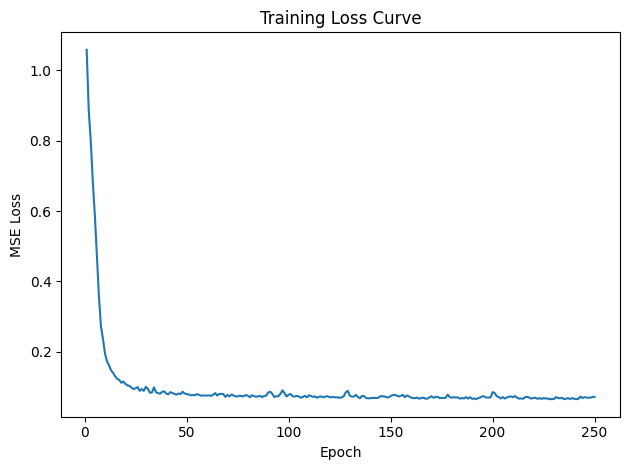

Fold 6 Training R²: 0.9365, Pearson r: 0.9679


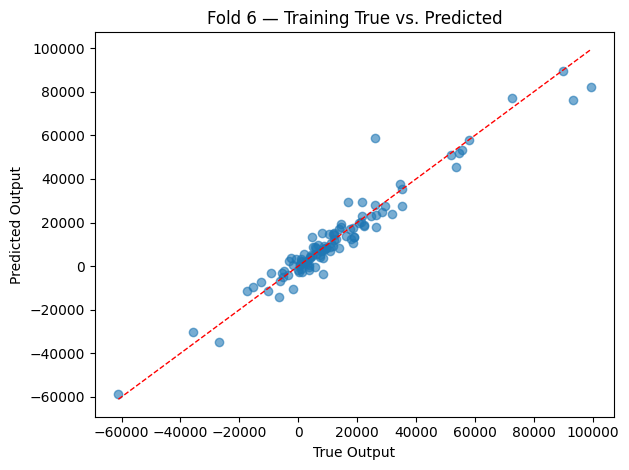

Fold 6 Validation MSE (norm): 1.0651
Fold 6 Validation R²: 0.0034, Pearson r: 0.5150


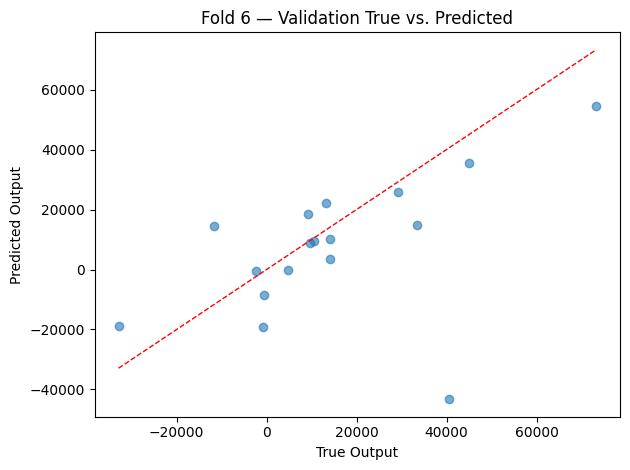


=== Fold 7/7 ===
Epoch   1/250  MSE=1.0111
Epoch  10/250  MSE=0.1934
Epoch  20/250  MSE=0.1352
Epoch  30/250  MSE=0.1246
Epoch  40/250  MSE=0.1111
Epoch  50/250  MSE=0.1065
Epoch  60/250  MSE=0.0990
Epoch  70/250  MSE=0.1041
Epoch  80/250  MSE=0.0904
Epoch  90/250  MSE=0.0919
Epoch 100/250  MSE=0.0856
Epoch 110/250  MSE=0.0868
Epoch 120/250  MSE=0.0885
Epoch 130/250  MSE=0.0823
Epoch 140/250  MSE=0.0936
Epoch 150/250  MSE=0.0800
Epoch 160/250  MSE=0.0842
Epoch 170/250  MSE=0.0834
Epoch 180/250  MSE=0.0795
Epoch 190/250  MSE=0.0823
Epoch 200/250  MSE=0.0790
Epoch 210/250  MSE=0.0781
Epoch 220/250  MSE=0.0761
Epoch 230/250  MSE=0.0781
Epoch 240/250  MSE=0.0869
Epoch 250/250  MSE=0.0807


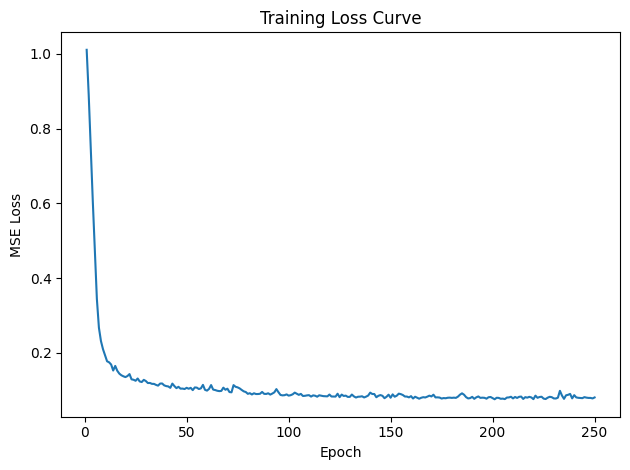

Fold 7 Training R²: 0.9336, Pearson r: 0.9665


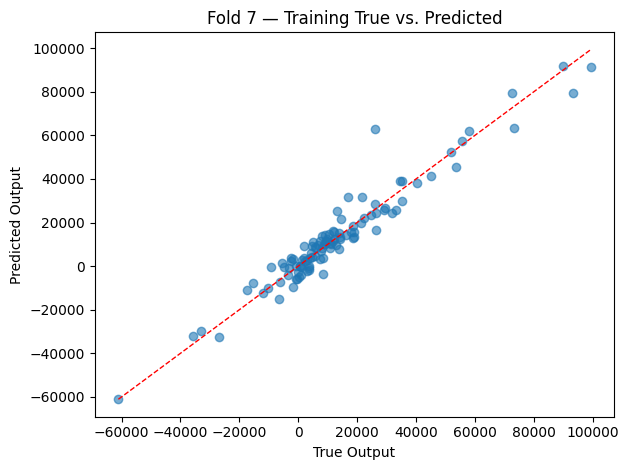

Fold 7 Validation MSE (norm): 0.2396
Fold 7 Validation R²: 0.4289, Pearson r: 0.7582


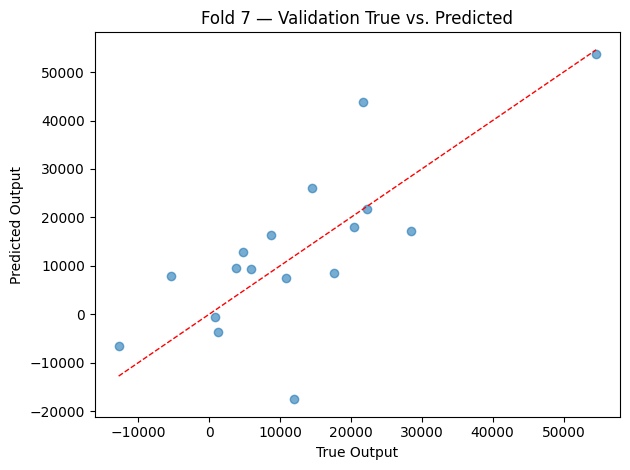


=== Validation MSE per fold ===
['0.1374', '0.1699', '0.2771', '1.0985', '0.2029', '1.0651', '0.2396']
Mean MSE (norm): 0.4558 ± 0.3982

=== Validation R² per fold ===
['0.3130', '0.8773', '0.6177', '0.4943', '0.7415', '0.0034', '0.4289']
Mean R²: 0.4966 ± 0.2676

=== Validation Pearson r per fold ===
['0.7260', '0.9384', '0.9125', '0.7169', '0.9202', '0.5150', '0.7582']
Mean Pearson r: 0.7839 ± 0.1413


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [44]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [8,8],
    'activation':  'linear',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# [16,8,4],'linear',


=== Fold 1/7 ===


Epoch   1/250  MSE=1.2804
Epoch  10/250  MSE=0.2025
Epoch  20/250  MSE=0.1500
Epoch  30/250  MSE=0.1284
Epoch  40/250  MSE=0.1122
Epoch  50/250  MSE=0.1035
Epoch  60/250  MSE=0.1027
Epoch  70/250  MSE=0.0970
Epoch  80/250  MSE=0.0913
Epoch  90/250  MSE=0.0951
Epoch 100/250  MSE=0.0918
Epoch 110/250  MSE=0.1027
Epoch 120/250  MSE=0.0856
Epoch 130/250  MSE=0.0864
Epoch 140/250  MSE=0.0863
Epoch 150/250  MSE=0.0884
Epoch 160/250  MSE=0.0884
Epoch 170/250  MSE=0.0810
Epoch 180/250  MSE=0.0805
Epoch 190/250  MSE=0.0847
Epoch 200/250  MSE=0.0836
Epoch 210/250  MSE=0.0827
Epoch 220/250  MSE=0.0856
Epoch 230/250  MSE=0.0866
Epoch 240/250  MSE=0.0852
Epoch 250/250  MSE=0.0824


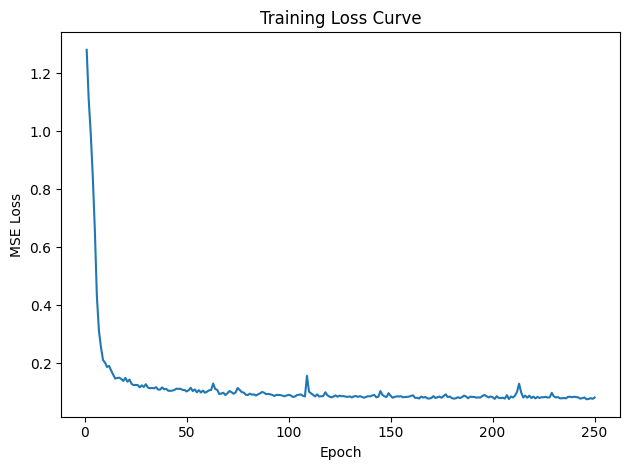

Fold 1 Training R²: 0.9328, Pearson r: 0.9663


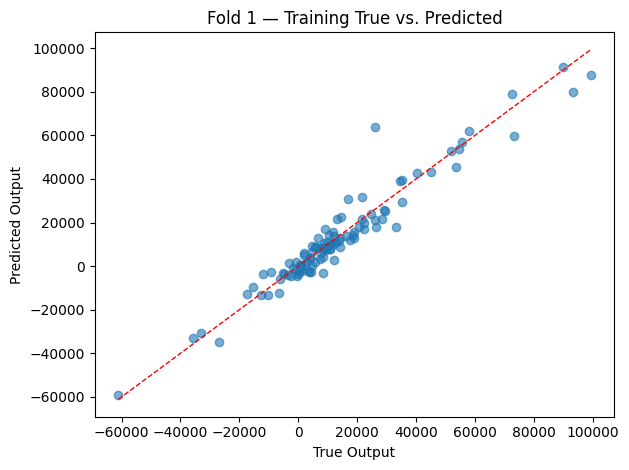

Fold 1 Validation MSE (norm): 0.1354
Fold 1 Validation R²: 0.3227, Pearson r: 0.7195


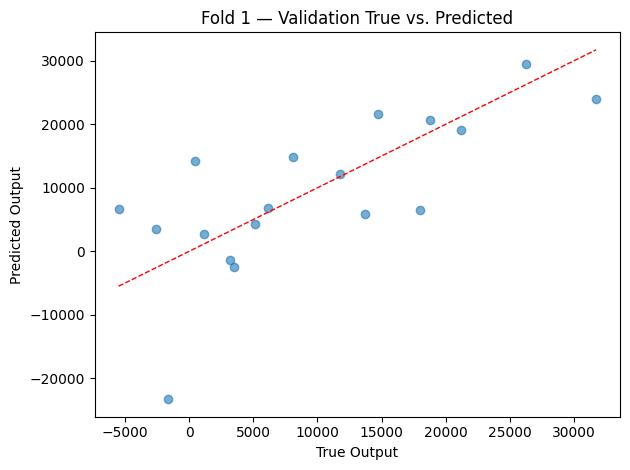


=== Fold 2/7 ===
Epoch   1/250  MSE=0.8625
Epoch  10/250  MSE=0.1963
Epoch  20/250  MSE=0.1256
Epoch  30/250  MSE=0.1179
Epoch  40/250  MSE=0.1051
Epoch  50/250  MSE=0.1019
Epoch  60/250  MSE=0.1117
Epoch  70/250  MSE=0.0977
Epoch  80/250  MSE=0.1037
Epoch  90/250  MSE=0.0891
Epoch 100/250  MSE=0.0860
Epoch 110/250  MSE=0.1029
Epoch 120/250  MSE=0.0999
Epoch 130/250  MSE=0.0934
Epoch 140/250  MSE=0.0805
Epoch 150/250  MSE=0.0806
Epoch 160/250  MSE=0.0816
Epoch 170/250  MSE=0.0799
Epoch 180/250  MSE=0.0808
Epoch 190/250  MSE=0.0873
Epoch 200/250  MSE=0.0787
Epoch 210/250  MSE=0.0769
Epoch 220/250  MSE=0.0863
Epoch 230/250  MSE=0.0798
Epoch 240/250  MSE=0.0858
Epoch 250/250  MSE=0.0759


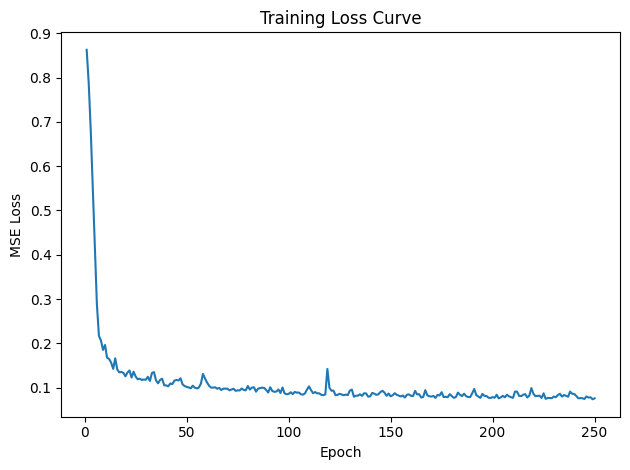

Fold 2 Training R²: 0.9242, Pearson r: 0.9614


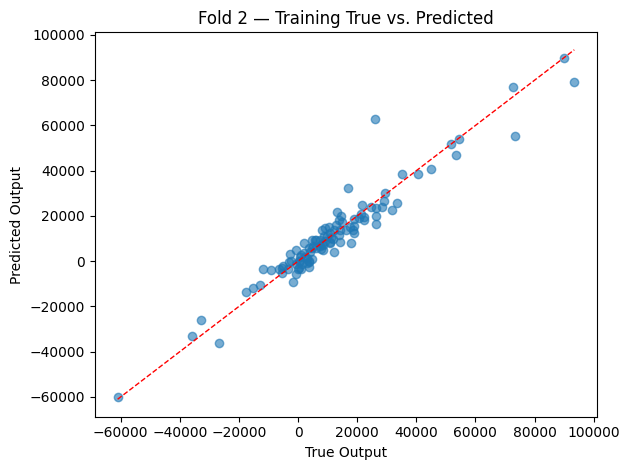

Fold 2 Validation MSE (norm): 0.1656
Fold 2 Validation R²: 0.8804, Pearson r: 0.9409


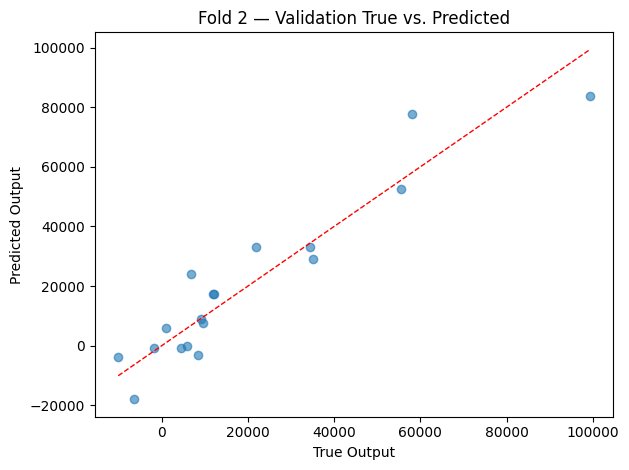


=== Fold 3/7 ===
Epoch   1/250  MSE=1.0399
Epoch  10/250  MSE=0.1679
Epoch  20/250  MSE=0.1001
Epoch  30/250  MSE=0.0755
Epoch  40/250  MSE=0.0668
Epoch  50/250  MSE=0.0629
Epoch  60/250  MSE=0.0798
Epoch  70/250  MSE=0.0584
Epoch  80/250  MSE=0.0657
Epoch  90/250  MSE=0.0535
Epoch 100/250  MSE=0.0573
Epoch 110/250  MSE=0.0607
Epoch 120/250  MSE=0.0546
Epoch 130/250  MSE=0.0536
Epoch 140/250  MSE=0.0537
Epoch 150/250  MSE=0.0539
Epoch 160/250  MSE=0.0572
Epoch 170/250  MSE=0.0605
Epoch 180/250  MSE=0.0560
Epoch 190/250  MSE=0.0491
Epoch 200/250  MSE=0.0504
Epoch 210/250  MSE=0.0486
Epoch 220/250  MSE=0.0501
Epoch 230/250  MSE=0.0558
Epoch 240/250  MSE=0.0522
Epoch 250/250  MSE=0.0525


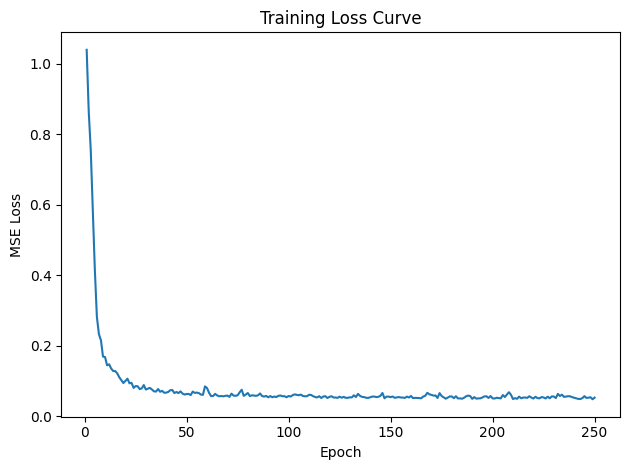

Fold 3 Training R²: 0.9557, Pearson r: 0.9778


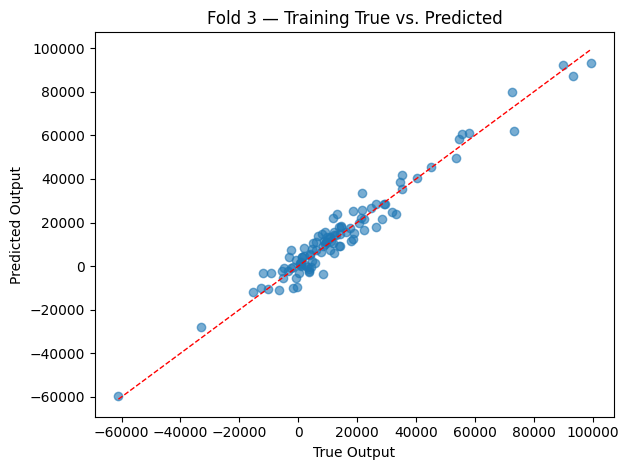

Fold 3 Validation MSE (norm): 0.3328
Fold 3 Validation R²: 0.5409, Pearson r: 0.9148


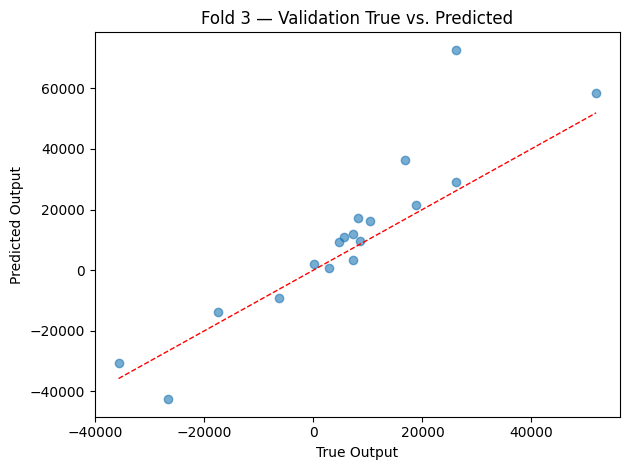


=== Fold 4/7 ===
Epoch   1/250  MSE=0.8267
Epoch  10/250  MSE=0.1421
Epoch  20/250  MSE=0.0886
Epoch  30/250  MSE=0.0826
Epoch  40/250  MSE=0.0818
Epoch  50/250  MSE=0.0758
Epoch  60/250  MSE=0.0743
Epoch  70/250  MSE=0.0751
Epoch  80/250  MSE=0.0856
Epoch  90/250  MSE=0.0723
Epoch 100/250  MSE=0.0724
Epoch 110/250  MSE=0.0736
Epoch 120/250  MSE=0.0727
Epoch 130/250  MSE=0.0749
Epoch 140/250  MSE=0.0729
Epoch 150/250  MSE=0.0744
Epoch 160/250  MSE=0.0738
Epoch 170/250  MSE=0.0748
Epoch 180/250  MSE=0.0761
Epoch 190/250  MSE=0.0737
Epoch 200/250  MSE=0.0828
Epoch 210/250  MSE=0.0725
Epoch 220/250  MSE=0.0760
Epoch 230/250  MSE=0.0692
Epoch 240/250  MSE=0.0736
Epoch 250/250  MSE=0.0706


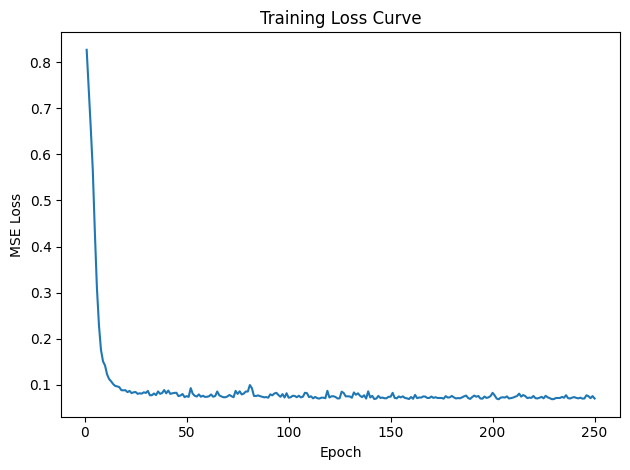

Fold 4 Training R²: 0.9172, Pearson r: 0.9579


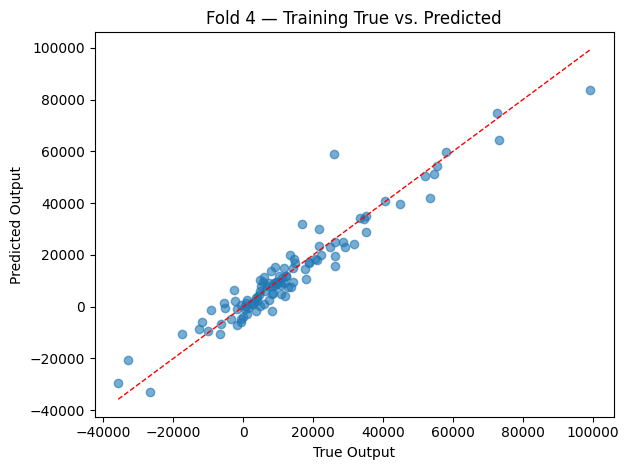

Fold 4 Validation MSE (norm): 1.0921
Fold 4 Validation R²: 0.4973, Pearson r: 0.7161


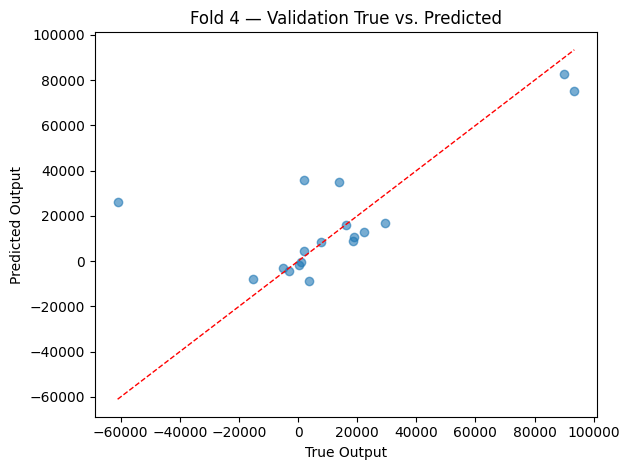


=== Fold 5/7 ===
Epoch   1/250  MSE=1.0592
Epoch  10/250  MSE=0.2089
Epoch  20/250  MSE=0.1251
Epoch  30/250  MSE=0.1190
Epoch  40/250  MSE=0.1130
Epoch  50/250  MSE=0.1078
Epoch  60/250  MSE=0.0962
Epoch  70/250  MSE=0.0967
Epoch  80/250  MSE=0.0880
Epoch  90/250  MSE=0.0900
Epoch 100/250  MSE=0.0903
Epoch 110/250  MSE=0.0928
Epoch 120/250  MSE=0.0866
Epoch 130/250  MSE=0.0914
Epoch 140/250  MSE=0.0875
Epoch 150/250  MSE=0.0817
Epoch 160/250  MSE=0.0796
Epoch 170/250  MSE=0.0829
Epoch 180/250  MSE=0.0823
Epoch 190/250  MSE=0.0816
Epoch 200/250  MSE=0.1109
Epoch 210/250  MSE=0.0855
Epoch 220/250  MSE=0.0851
Epoch 230/250  MSE=0.0855
Epoch 240/250  MSE=0.0867
Epoch 250/250  MSE=0.0912


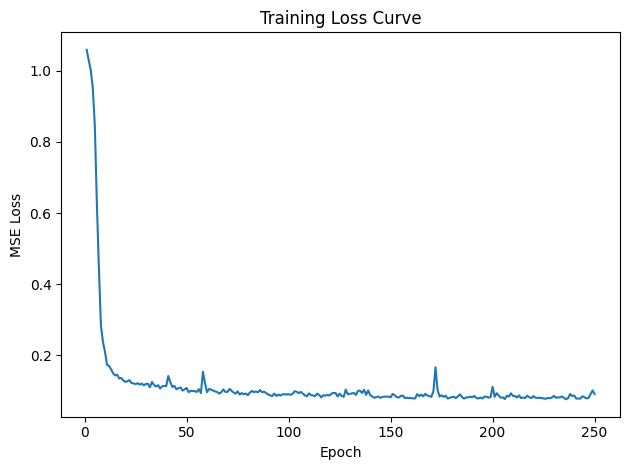

Fold 5 Training R²: 0.9283, Pearson r: 0.9639


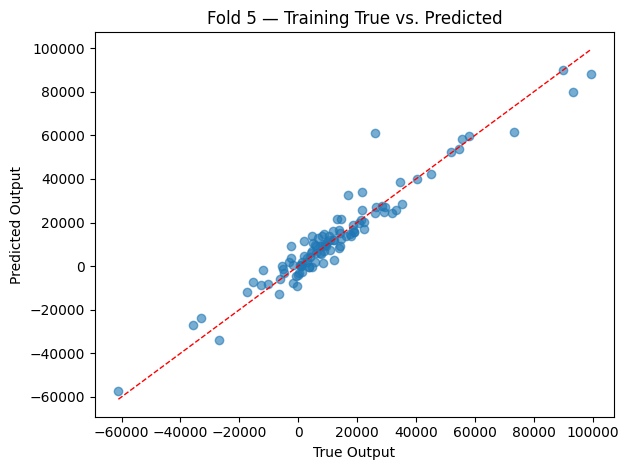

Fold 5 Validation MSE (norm): 0.1994
Fold 5 Validation R²: 0.7461, Pearson r: 0.9192


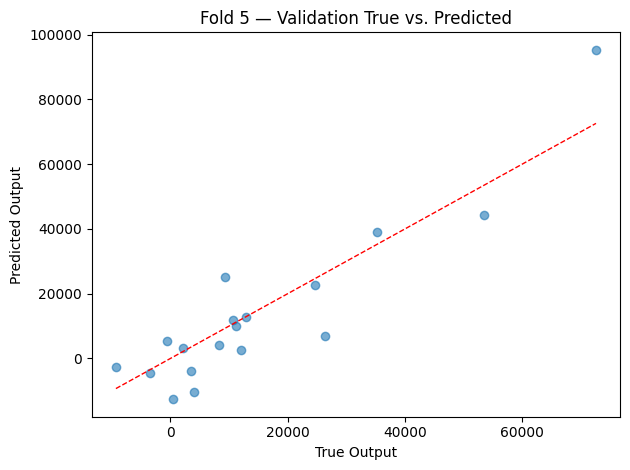


=== Fold 6/7 ===
Epoch   1/250  MSE=1.2782
Epoch  10/250  MSE=0.1782
Epoch  20/250  MSE=0.0976
Epoch  30/250  MSE=0.0830
Epoch  40/250  MSE=0.0864
Epoch  50/250  MSE=0.0772
Epoch  60/250  MSE=0.0780
Epoch  70/250  MSE=0.0731
Epoch  80/250  MSE=0.0722
Epoch  90/250  MSE=0.0708
Epoch 100/250  MSE=0.0776
Epoch 110/250  MSE=0.0690
Epoch 120/250  MSE=0.0712
Epoch 130/250  MSE=0.0736
Epoch 140/250  MSE=0.0831
Epoch 150/250  MSE=0.0997
Epoch 160/250  MSE=0.0682
Epoch 170/250  MSE=0.0665
Epoch 180/250  MSE=0.0705
Epoch 190/250  MSE=0.0681
Epoch 200/250  MSE=0.0681
Epoch 210/250  MSE=0.0747
Epoch 220/250  MSE=0.0681
Epoch 230/250  MSE=0.0709
Epoch 240/250  MSE=0.0694
Epoch 250/250  MSE=0.0746


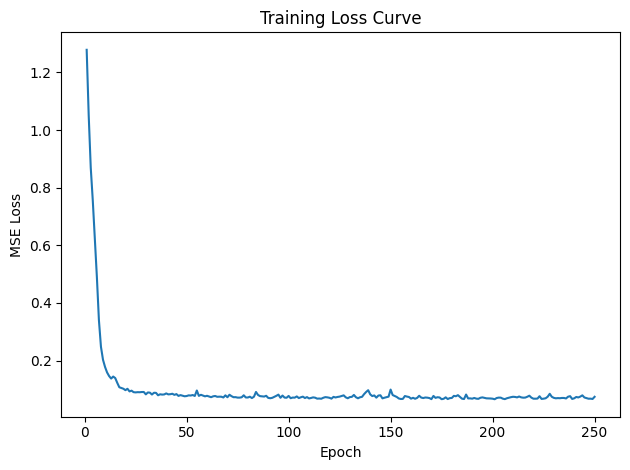

Fold 6 Training R²: 0.9359, Pearson r: 0.9677


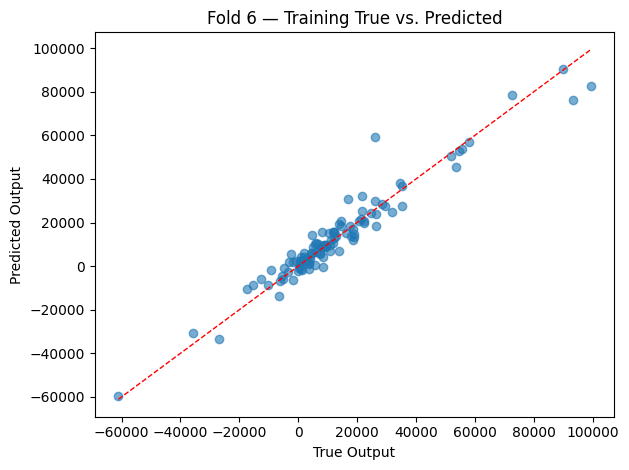

Fold 6 Validation MSE (norm): 1.1163
Fold 6 Validation R²: -0.0445, Pearson r: 0.4909


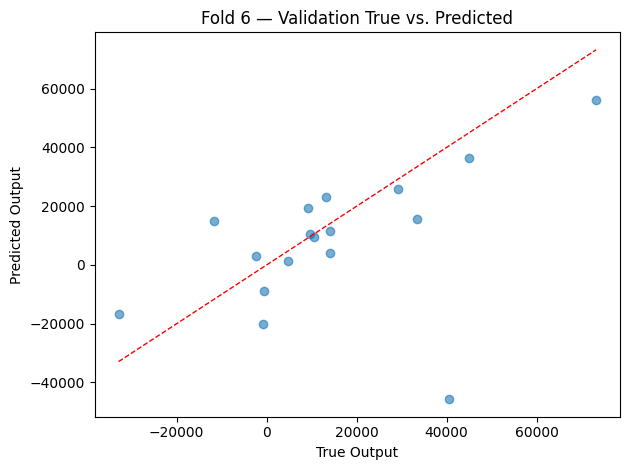


=== Fold 7/7 ===
Epoch   1/250  MSE=1.2653
Epoch  10/250  MSE=0.2328
Epoch  20/250  MSE=0.1425
Epoch  30/250  MSE=0.1144
Epoch  40/250  MSE=0.1070
Epoch  50/250  MSE=0.1048
Epoch  60/250  MSE=0.1046
Epoch  70/250  MSE=0.0951
Epoch  80/250  MSE=0.0889
Epoch  90/250  MSE=0.0899
Epoch 100/250  MSE=0.0840
Epoch 110/250  MSE=0.0908
Epoch 120/250  MSE=0.0833
Epoch 130/250  MSE=0.0965
Epoch 140/250  MSE=0.0812
Epoch 150/250  MSE=0.0814
Epoch 160/250  MSE=0.0779
Epoch 170/250  MSE=0.0840
Epoch 180/250  MSE=0.0858
Epoch 190/250  MSE=0.0817
Epoch 200/250  MSE=0.0859
Epoch 210/250  MSE=0.0781
Epoch 220/250  MSE=0.0774
Epoch 230/250  MSE=0.0774
Epoch 240/250  MSE=0.0859
Epoch 250/250  MSE=0.0745


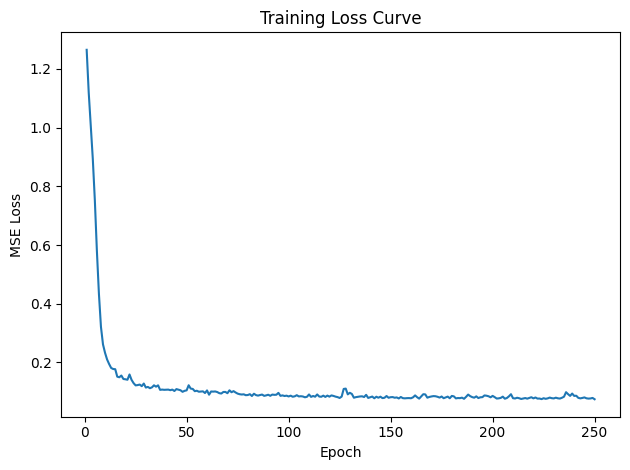

Fold 7 Training R²: 0.9348, Pearson r: 0.9669


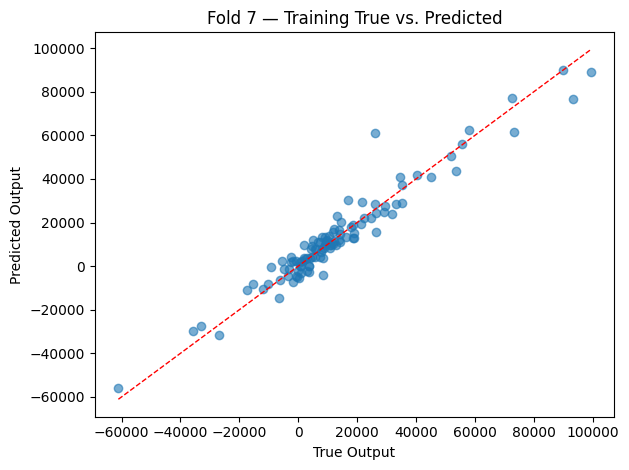

Fold 7 Validation MSE (norm): 0.2537
Fold 7 Validation R²: 0.3954, Pearson r: 0.7344


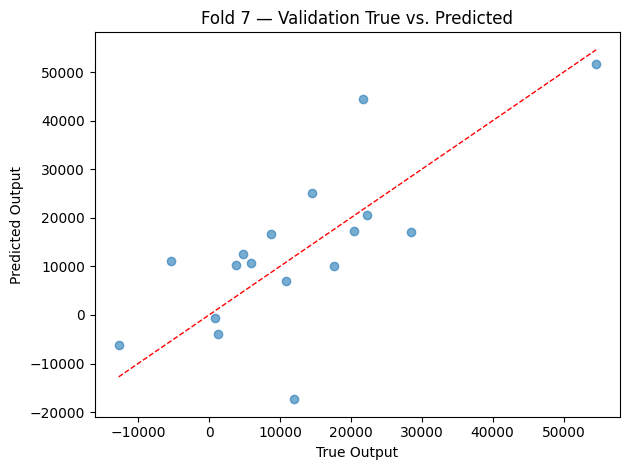


=== Validation MSE per fold ===
['0.1354', '0.1656', '0.3328', '1.0921', '0.1994', '1.1163', '0.2537']
Mean MSE (norm): 0.4708 ± 0.4050

=== Validation R² per fold ===
['0.3227', '0.8804', '0.5409', '0.4973', '0.7461', '-0.0445', '0.3954']
Mean R²: 0.4769 ± 0.2783

=== Validation Pearson r per fold ===
['0.7195', '0.9409', '0.9148', '0.7161', '0.9192', '0.4909', '0.7344']
Mean Pearson r: 0.7766 ± 0.1497


'\n# 5) Save each fold’s model weights\nfor i, model in enumerate(models, 1):\n    model_fp = f"trained_model_{tag}_fold{i}.pt"\n    torch.save(model.state_dict(), model_fp)\n    print(f"Saved fold {i} weights to: {model_fp}")\n\n# 6) Save the hyper-parameters once\nparams_fp = f"trained_model_{tag}_params.txt"\nwith open(params_fp, \'w\') as f:\n    for name, val in hyperparams.items():\n        f.write(f"{name}: {val}\n")\nprint(f"Saved training hyper-parameters to: {params_fp}")\n'

In [45]:
import uuid

# 1) Generate a short random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [16,8,4],
    'activation':  'linear',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      250,
    'batch_size':  8
}

# 3) Run cross-validated training
#    Assumes train_nn_cv(X, y, **hyperparams, cv=5) is already defined
models, val_losses = train_nn_cv(
    X, y, scaler_y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size'],
    cv            = 7
)

'''# 4) (Optional) Print per-fold validation MSE
for i, mse in enumerate(val_losses, 1):
    print(f"Fold {i} Validation MSE = {mse:.4f}")'''

'''
# 5) Save each fold’s model weights
for i, model in enumerate(models, 1):
    model_fp = f"trained_model_{tag}_fold{i}.pt"
    torch.save(model.state_dict(), model_fp)
    print(f"Saved fold {i} weights to: {model_fp}")

# 6) Save the hyper-parameters once
params_fp = f"trained_model_{tag}_params.txt"
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")
print(f"Saved training hyper-parameters to: {params_fp}")
'''

# singel run

Epoch   1/2000  MSE=1.5210
Epoch  10/2000  MSE=1.1934
Epoch  20/2000  MSE=0.9173
Epoch  30/2000  MSE=0.7359
Epoch  40/2000  MSE=0.6430
Epoch  50/2000  MSE=0.5786
Epoch  60/2000  MSE=0.5091
Epoch  70/2000  MSE=0.4301
Epoch  80/2000  MSE=0.3793
Epoch  90/2000  MSE=0.3408
Epoch 100/2000  MSE=0.3095
Epoch 110/2000  MSE=0.2839
Epoch 120/2000  MSE=0.2634
Epoch 130/2000  MSE=0.2455
Epoch 140/2000  MSE=0.2190
Epoch 150/2000  MSE=0.1954
Epoch 160/2000  MSE=0.1634
Epoch 170/2000  MSE=0.1492
Epoch 180/2000  MSE=0.1352
Epoch 190/2000  MSE=0.1252
Epoch 200/2000  MSE=0.1163
Epoch 210/2000  MSE=0.1098
Epoch 220/2000  MSE=0.1034
Epoch 230/2000  MSE=0.0997
Epoch 240/2000  MSE=0.0958
Epoch 250/2000  MSE=0.0976
Epoch 260/2000  MSE=0.0892
Epoch 270/2000  MSE=0.0865
Epoch 280/2000  MSE=0.0857
Epoch 290/2000  MSE=0.0850
Epoch 300/2000  MSE=0.0827
Epoch 310/2000  MSE=0.0816
Epoch 320/2000  MSE=0.0783
Epoch 330/2000  MSE=0.0742
Epoch 340/2000  MSE=0.0682
Epoch 350/2000  MSE=0.0671
Epoch 360/2000  MSE=0.0663
E

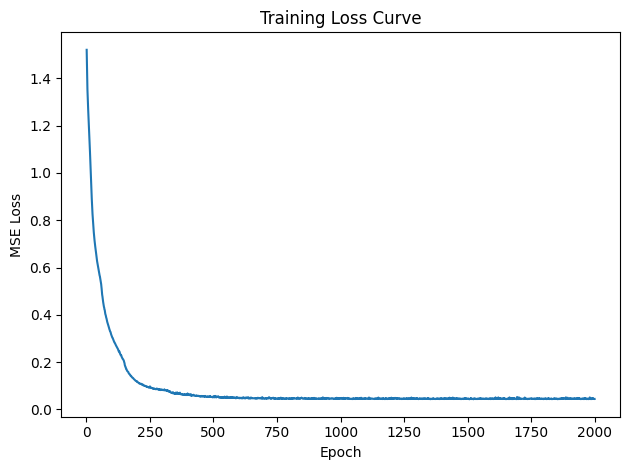

NameError: name 'plot_train_scatter' is not defined

In [46]:
import uuid
import torch

# 1) Generate a random tag
tag = uuid.uuid4().hex[:8]

# 2) Your hyper-parameters
hyperparams = {
    'hidden_dims': [2, 2],
    'activation':  'ReLU',
    'lr':          2e-3,
    'weight_decay':5e-5,
    'epochs':      2000,
    'batch_size':  8
}

# 3) Train your model
model, losses = train_nn(
    X, y,
    hidden_dims   = hyperparams['hidden_dims'],
    activation    = hyperparams['activation'],
    lr            = hyperparams['lr'],
    weight_decay  = hyperparams['weight_decay'],
    epochs        = hyperparams['epochs'],
    batch_size    = hyperparams['batch_size']
)

# 4) Plot true vs. predicted
plot_train_scatter(model, X, y, scaler_y=scaler_y, device='cpu')

# 5) Construct filenames with tag
model_fp  = f"trained_model_{tag}.pt"
params_fp = f"trained_model_{tag}_params.txt"

# 6) Save the model weights
torch.save(model.state_dict(), model_fp)

# 7) Save the hyper-parameters
with open(params_fp, 'w') as f:
    for name, val in hyperparams.items():
        f.write(f"{name}: {val}\n")

print(f"Saved model to:  {model_fp}")
print(f"Saved params to: {params_fp}")
